# Project 4 - Unsupervised Learning 
## Author - [Shekar Roy](https://github.com/shekarroy15)

# Part 1/5

# DOMAIN: 
Automobile

### CONTEXT:

The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes
### DATA DESCRIPTION:

The data concerns city-cycle fuel consumption in miles per gallon
### Attribute Information:

    1- mpg: continuous
    2- cylinders(cyl): multi-valued discrete
    3- displacement(disp): continuous
    4- horsepower(hp): continuous
    5- weight(wt): continuous
    6- acceleration(acc): continuous
    7- model year(yr): multi-valued discrete
    8- origin: multi-valued discrete
    9- car name: string (unique for each instance)

### PROJECT OBJECTIVE:

Goal is to cluster the data and treat them as individual datasets to train Regression models to predict ‘mpg’


In [1]:
import numpy as np   
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from scipy import stats 
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# Merge all datasets onto one and explore final shape and size.

ca = pd.read_json('Part1 - Car-Attributes.json')
ca1 = pd.read_csv('Part1 - Car name.csv')
df1 = pd.concat([ca,ca1],axis=1)
df1.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
# Final Shape of the merged dataset

row, column = df1.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 398 rows and 9 columns


In [4]:
# Export the final dataset and store it on local machine in .csv, .xlsx and .json format for future use.

df1.to_csv('mpg.csv', index=False)
df1.to_excel('mpg.xlsx', index = False)
df1.to_json('mpg.json', orient = 'split', compression = 'infer', index = 'true')

In [5]:
# Import the data from above steps into python.

car = pd.read_csv('mpg.csv')
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [6]:
# Missing/incorrect value treatment

# Dropping car name, as that is of least importance.

car = car.drop('car_name', axis=1)
# Also replacing the categorical var with actual values
car['origin'] = car['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin
0,18.0,8,307.0,130,3504,12.0,70,america
1,15.0,8,350.0,165,3693,11.5,70,america
2,18.0,8,318.0,150,3436,11.0,70,america
3,16.0,8,304.0,150,3433,12.0,70,america
4,17.0,8,302.0,140,3449,10.5,70,america


In [7]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     398 non-null    float64
 1   cyl     398 non-null    int64  
 2   disp    398 non-null    float64
 3   hp      398 non-null    object 
 4   wt      398 non-null    int64  
 5   acc     398 non-null    float64
 6   yr      398 non-null    int64  
 7   origin  398 non-null    object 
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


In [8]:
car.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0


In [9]:
# isdigit()? on 'horsepower' 
hpIsDigit = pd.DataFrame(car.hp.str.isdigit()) 

#print isDigit = False!
car[hpIsDigit['hp'] == False]

,mpg,cyl,disp,hp,wt,acc,yr,origin
32,25.0,4,98.0,?,2046,19.0,71,america
126,21.0,6,200.0,?,2875,17.0,74,america
330,40.9,4,85.0,?,1835,17.3,80,europe
336,23.6,4,140.0,?,2905,14.3,80,america
354,34.5,4,100.0,?,2320,15.8,81,europe
374,23.0,4,151.0,?,3035,20.5,82,america


##### There are various ways to handle missing values. Drop the rows, replace missing values with median values etc. of the 398 rows 6 have NAN in the hp column. We could drop those 6 rows - which might not be a good idea under all situations. Here, we will replace them with their median values. First replace '?' with NaN and then replace NaN with median

In [10]:
# Replace missing values with NaN
car = car.replace('?', np.nan)
car[hpIsDigit['hp'] == False]

,mpg,cyl,disp,hp,wt,acc,yr,origin
32,25.0,4,98.0,NaN,2046,19.0,71,america
126,21.0,6,200.0,NaN,2875,17.0,74,america
330,40.9,4,85.0,NaN,1835,17.3,80,europe
336,23.6,4,140.0,NaN,2905,14.3,80,america
354,34.5,4,100.0,NaN,2320,15.8,81,europe
374,23.0,4,151.0,NaN,3035,20.5,82,america


In [11]:
car.median()

mpg       23.0
cyl        4.0
disp     148.5
hp        93.5
wt      2803.5
acc       15.5
yr        76.0
dtype: float64

In [12]:
car['hp'].fillna((car['hp'].median()), inplace=True)
car['hp'] = car.hp.astype(float)

In [13]:
print('The data set has no missing values \n')
car.isnull().sum()

The data set has no missing values 



mpg       0
cyl       0
disp      0
hp        0
wt        0
acc       0
yr        0
origin    0
dtype: int64

In [14]:
#creating mpg_level attribute using the 25% and 75% of mpg values( <  17 as low, > 17 and <29 as medium, > 29 as high  )
car['mpg_level'] = car['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
car.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,mpg_level
0,18.0,8,307.0,130.0,3504,12.0,70,america,medium
1,15.0,8,350.0,165.0,3693,11.5,70,america,low
2,18.0,8,318.0,150.0,3436,11.0,70,america,medium
3,16.0,8,304.0,150.0,3433,12.0,70,america,low
4,17.0,8,302.0,140.0,3449,10.5,70,america,medium


In [15]:
#categorical variable
car_cat = car.iloc[:,[1,6,7,8]]
car_cat.head()

,cyl,yr,origin,mpg_level
0,8,70,america,medium
1,8,70,america,low
2,8,70,america,medium
3,8,70,america,low
4,8,70,america,medium


In [16]:
#numeric variables
car_num=car.drop(['cyl','yr','origin','mpg_level'],axis=1)
car_num.head()

,mpg,disp,hp,wt,acc
0,18.0,307.0,130.0,3504,12.0
1,15.0,350.0,165.0,3693,11.5
2,18.0,318.0,150.0,3436,11.0
3,16.0,304.0,150.0,3433,12.0
4,17.0,302.0,140.0,3449,10.5


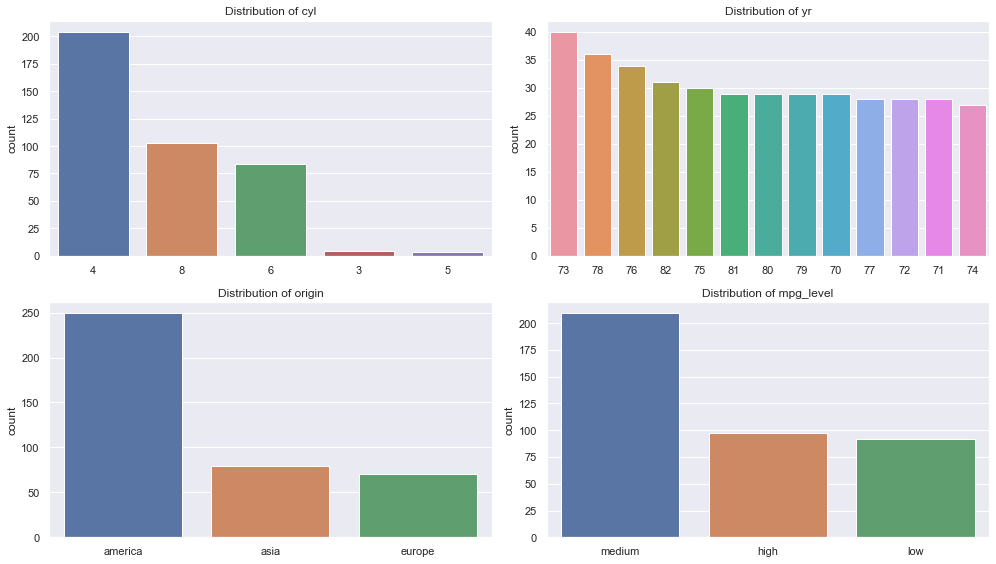

In [17]:
# plotting categorical variables
fig = plt.figure(1, (14, 8))

for i,car in enumerate(car_cat.columns):
    ax = plt.subplot(2,2,i+1)
    sns.countplot(car_cat[car], order=car_cat[car].value_counts().index)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {car}')
    plt.tight_layout()

plt.show()


#### Observation from above graph -> American 4 cylinder cars produced in 1973 with medium mpg level seem to dominate the dateset

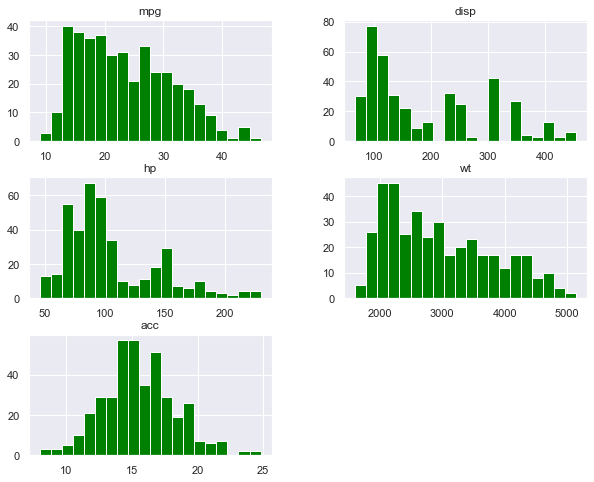

In [18]:
# Plotting the numerical values 
car_num.hist(bins = 20, figsize = (10, 8), color = 'green')
plt.show()

<Figure size 1224x936 with 0 Axes>

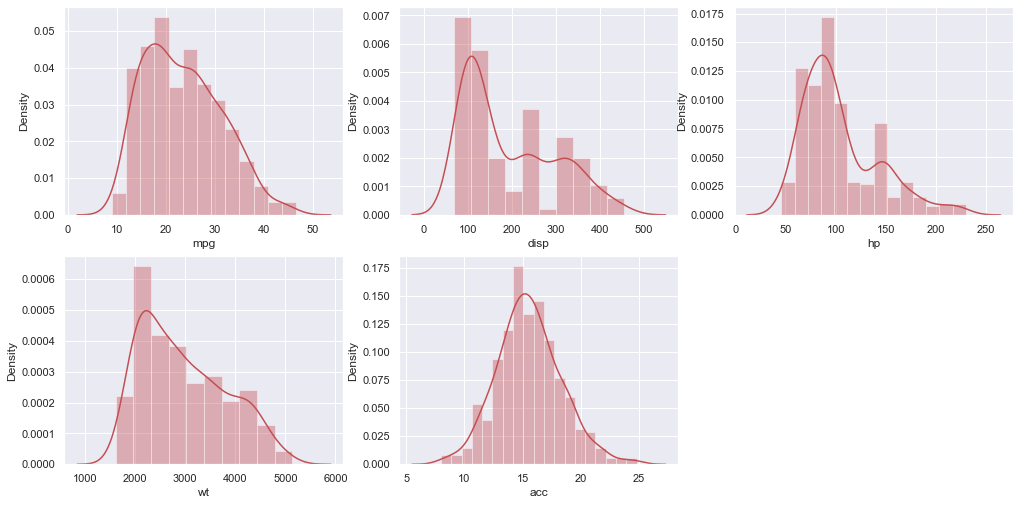

In [19]:
plt.figure(figsize=(17, 13))
plt.figure(figsize=(17, 13))
col = 1
for i in car_num.columns:
    plt.subplot(3, 3, col)
    sns.distplot(car_num[i], color = 'r');
    col += 1

Displacement and Horsepower seem to be skewed to the right 

In [20]:
#joining the categorical and numerical variables
car=pd.concat([car_cat,car_num],axis=1)
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   cyl        398 non-null    int64  
 1   yr         398 non-null    int64  
 2   origin     398 non-null    object 
 3   mpg_level  398 non-null    object 
 4   mpg        398 non-null    float64
 5   disp       398 non-null    float64
 6   hp         398 non-null    float64
 7   wt         398 non-null    int64  
 8   acc        398 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [21]:
car = pd.get_dummies(car, columns=['origin'])
car = pd.get_dummies(car, columns=['mpg_level'])
car.head()
carH=car.copy()
carK=car.copy()

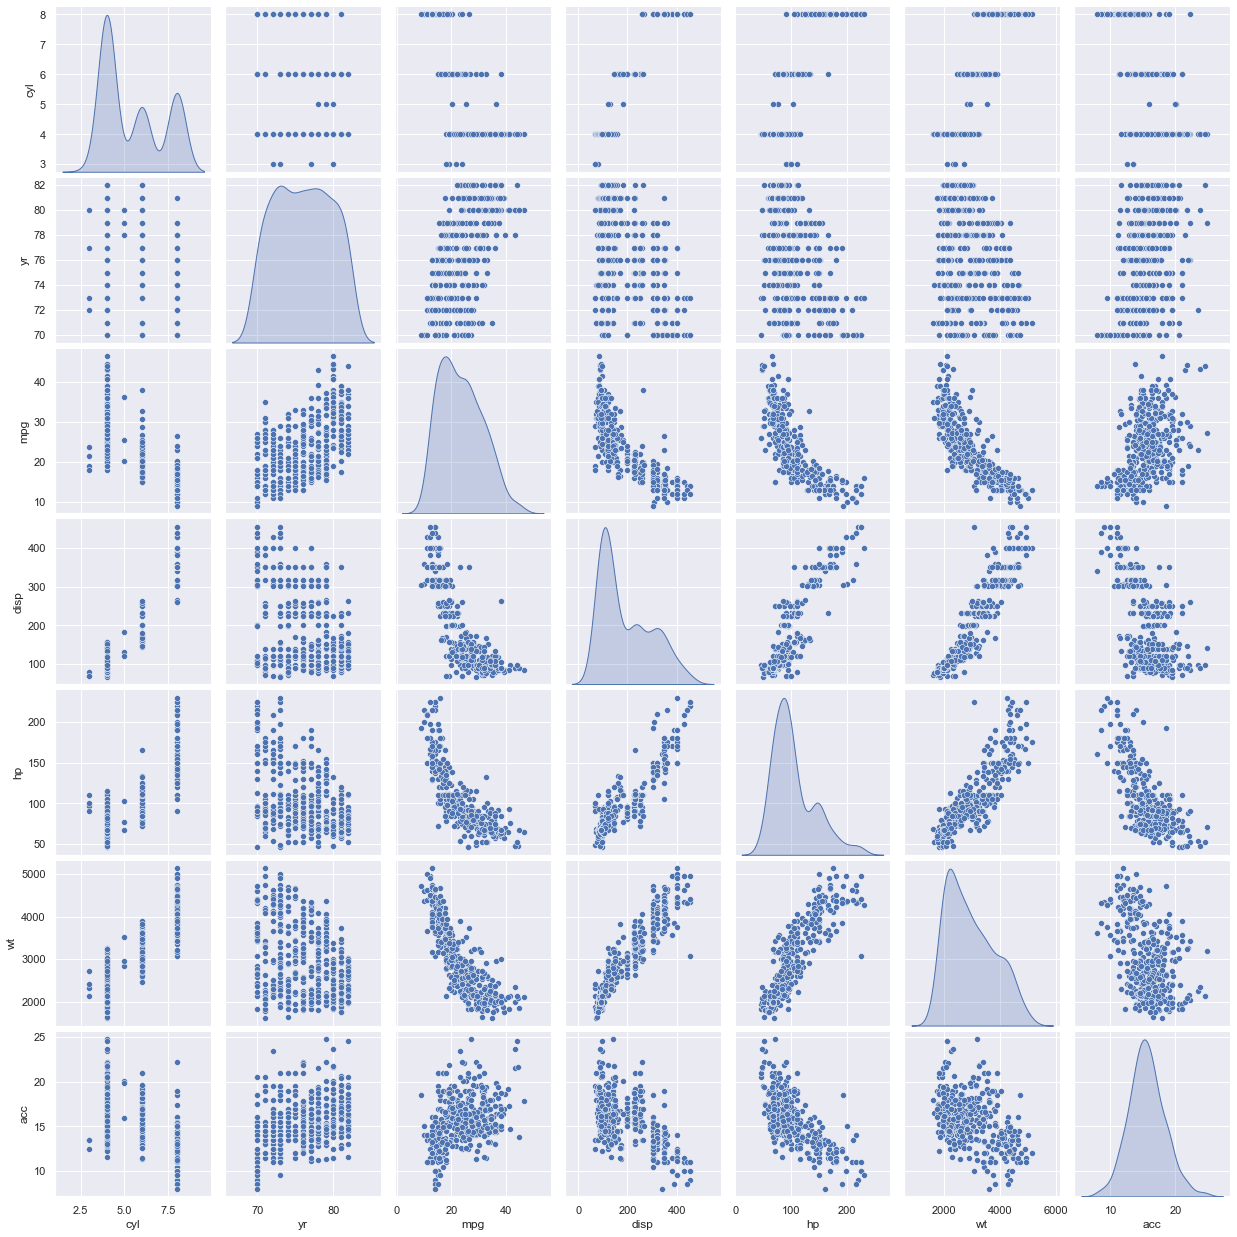

In [22]:
#pair plot for the numeric attributes
car_attr = car.iloc[:, 0:7]
sns.pairplot(car_attr, diag_kind='kde');

There appears to be a linear relationship between the variables

In [23]:
#dropping the created dummy variable
car2 = car.drop(['origin_america','origin_asia','origin_europe','mpg_level_high','mpg_level_low','mpg_level_medium'],axis=1)

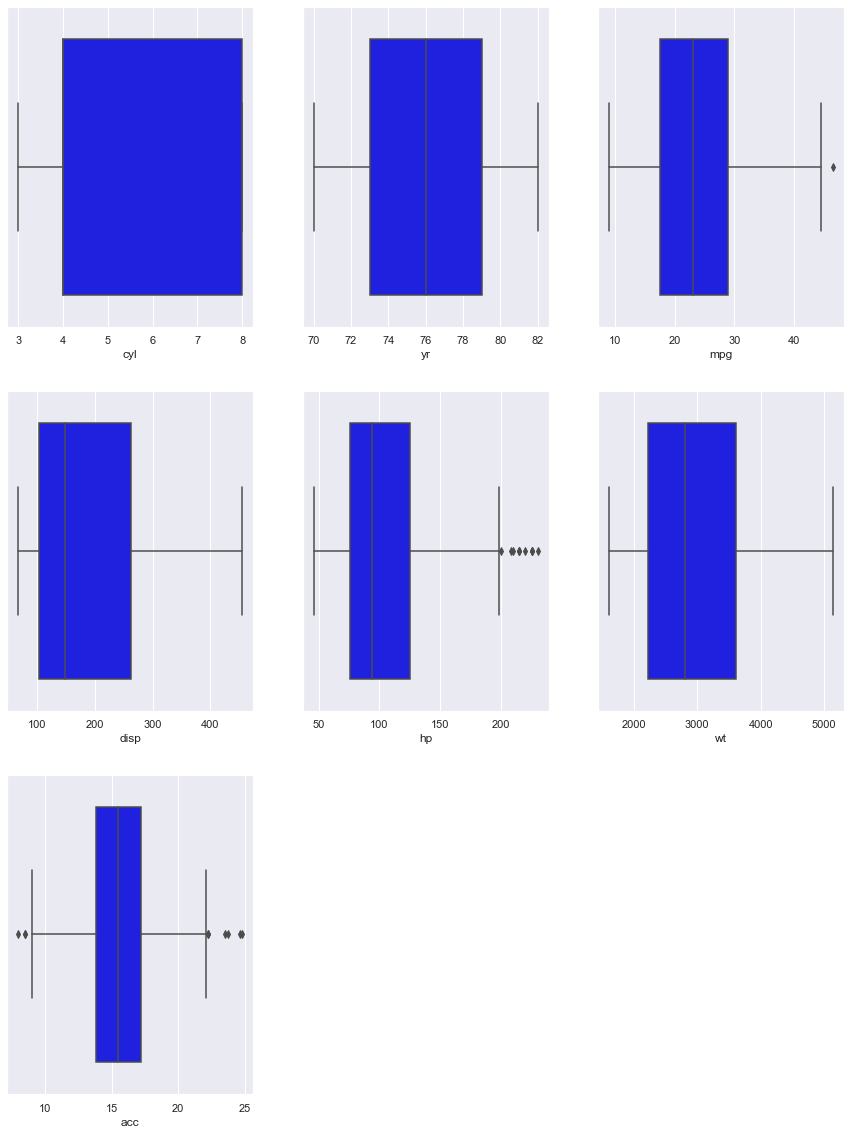

In [24]:
plt.figure(figsize=(15, 20))
col = 1
for i in car2.columns:
    plt.subplot(3, 3, col)
    sns.boxplot(car2[i],color='blue')
    col += 1

In [25]:
IQR1 = stats.iqr(car2['hp'], interpolation = 'midpoint')
IQR2 = stats.iqr(car2['acc'], interpolation = 'midpoint')

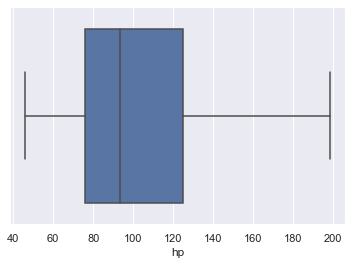

In [26]:
Q3 = car2['hp'].quantile(0.75)
car2['hp'] = np.where(car2["hp"] >(Q3+1.5*IQR1), 198.5,car2['hp'])
sns.boxplot(car2['hp']);

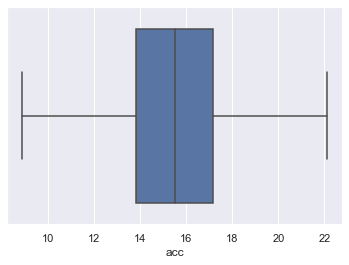

In [27]:
Q1 = car2['acc'].quantile(0.25)
Q31 = car2['acc'].quantile(0.75)
car2['acc'] = np.where(car2["acc"] >(Q31+1.5*IQR2),22.10 ,car2['acc'])
car2['acc'] = np.where(car2["acc"] <(Q1-1.5*IQR2),(Q1-1.5*IQR2),car2['acc'])
sns.boxplot(car2['acc']);

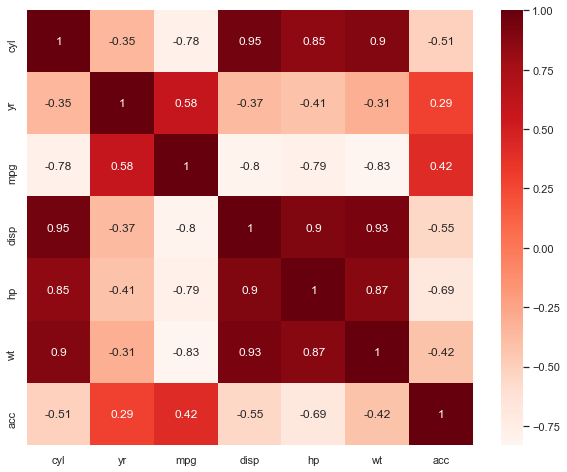

In [28]:
#checking for correlation
plt.figure(figsize = (10,8))
corr = car2.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds);

Except Year, most of the variable are correlated with each other

### Hierarchical clustering

In [29]:
# separating numeric variables
cc = car.iloc[:,0:7] 
cc.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,8,70,18.0,307.0,130.0,3504,12.0
1,8,70,15.0,350.0,165.0,3693,11.5
2,8,70,18.0,318.0,150.0,3436,11.0
3,8,70,16.0,304.0,150.0,3433,12.0
4,8,70,17.0,302.0,140.0,3449,10.5


In [30]:
# scaling the variable
cc_z = cc.apply(zscore)
cc_z.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117


In [31]:
#calculating pairwise distance using average linkage method
link_method = linkage(cc_z.iloc[:,0:7], method = 'average')

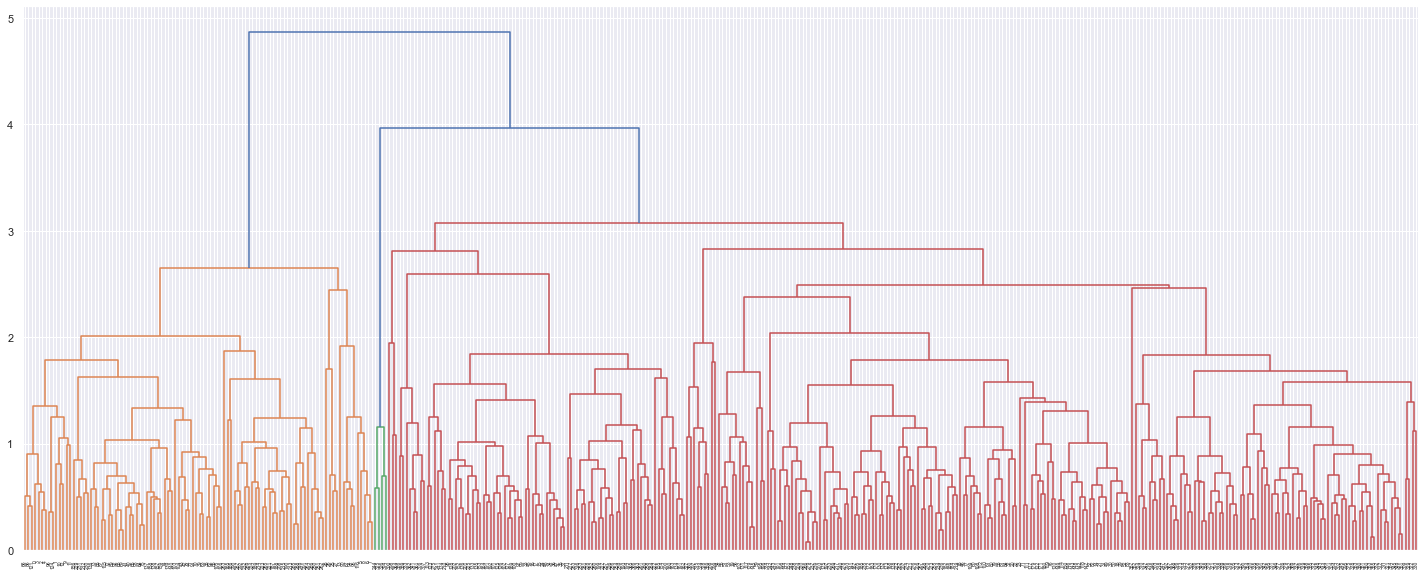

In [32]:
#plotting the H-cluster
plt.figure(figsize = (25, 10))
dendrogram(link_method)
plt.show()

#### Appears to be to a visual clutter. However if seen from top, there are 2 probable clusters seen. We will have to analyze it more to find that out. So now,  we'll go ahead and cut down the dendrogram to give us 2 clusters/groups

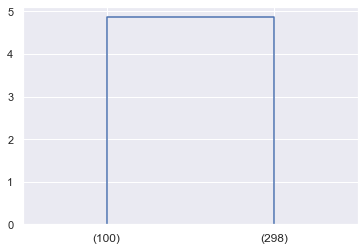

In [33]:
# dendrogram function to arrive at dendrogram
dendrogram(link_method,truncate_mode='lastp', p=2)
plt.show()

In [34]:
#viewing the clusters formed
clusters = fcluster(link_method, 2, criterion='maxclust')
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,

In [35]:
#attaching the clusters formed to the scales data
cc_z['clusters_H'] = clusters
cc_z.clusters_H.value_counts().sort_index()

1    100
2    298
Name: clusters_H, dtype: int64

In [36]:
#attaching the clusters formed to the original data
cc['clusters_H'] = clusters
carH['clusters_H'] = clusters
cc.head()

,cyl,yr,mpg,disp,hp,wt,acc,clusters_H
0,8,70,18.0,307.0,130.0,3504,12.0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1
2,8,70,18.0,318.0,150.0,3436,11.0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1
4,8,70,17.0,302.0,140.0,3449,10.5,1


In [37]:
# create a new data set named Hcluster
Hcluster=cc
Hcluster.head()

,cyl,yr,mpg,disp,hp,wt,acc,clusters_H
0,8,70,18.0,307.0,130.0,3504,12.0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1
2,8,70,18.0,318.0,150.0,3436,11.0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1
4,8,70,17.0,302.0,140.0,3449,10.5,1


In [38]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('clusters_H').mean()
aggdata['Freq']=cc.clusters_H.value_counts().sort_index()
aggdata

,cyl,yr,mpg,disp,hp,wt,acc,Freq
clusters_H,,,,,,,,
1,7.980000,73.740000,14.684000,345.470000,160.400000,4121.560000,12.702000,100
2,4.607383,76.771812,26.477852,142.404362,85.479866,2584.137584,16.529866,298


#### Clearly shows two distinct groups, with a difference in average between the clusters and variables

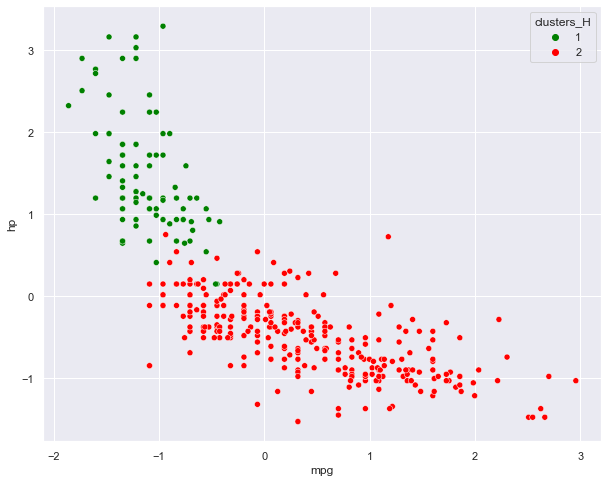

In [39]:
#plotting the clusters formed
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="clusters_H",data=cc_z, palette=['green','red']);

##  K-Means Clustering

In [40]:
# separating the numeric values and scaling them
cc = car.iloc[:,0:7] 
cc_z1 = cc.apply(zscore)
cc_z1.head()

,cyl,yr,mpg,disp,hp,wt,acc
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117


In [41]:
# calculating the within sum of squares
wss =[] 
for i in range(1,5):
    KM = KMeans(n_clusters=i)
    KM.fit(cc_z1)
    wss.append(KM.inertia_)
wss

[2785.9999999999995, 1295.0996383222816, 946.019790855379, 738.4159737149639]

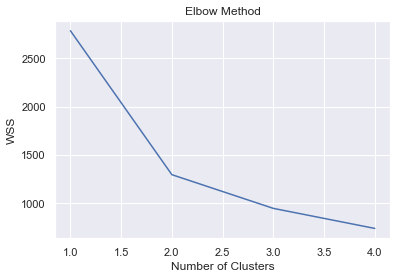

In [42]:
# plotting the WSS against the number of cluster to come up with optimal number of clusters using Elbow-method
plt.plot(range(1,5), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

In [43]:
#using 2 centroids for clustering
k_means = KMeans(n_clusters = 2)
k_means.fit(cc_z1)
labels = k_means.labels_

In [44]:
# Calculating silhouette_score
silhouette_score(cc_z1,labels)

0.48235946103916116

In [45]:
#calculating silhouette score for different centroids

kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

silhouette_coefficients = []


# Notice you start at 2 clusters for silhouette coefficient
    
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc_z1)
    score = silhouette_score(cc_z1,kmeans.labels_)
    silhouette_coefficients.append(score)

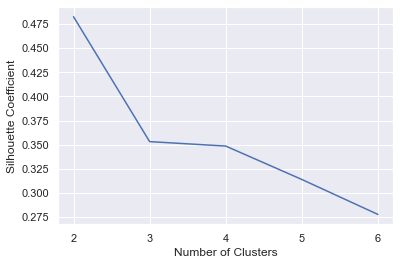

In [46]:
#plotting silhouette score for different centroids
plt.plot(range(2, 7), silhouette_coefficients)
plt.xticks(range(2, 7))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [47]:
#attaching the labels to the datasets
cc["cluster_K"] = labels
carK['cluster_K']=labels
Kclus=cc
Kclus.head()

,cyl,yr,mpg,disp,hp,wt,acc,cluster_K
0,8,70,18.0,307.0,130.0,3504,12.0,0
1,8,70,15.0,350.0,165.0,3693,11.5,0
2,8,70,18.0,318.0,150.0,3436,11.0,0
3,8,70,16.0,304.0,150.0,3433,12.0,0
4,8,70,17.0,302.0,140.0,3449,10.5,0


In [48]:
cc.cluster_K.value_counts().sort_index()

0    105
1    293
Name: cluster_K, dtype: int64

In [49]:
#attaching the clusters to the scaled data
cc_z1["cluster_K"] = labels
cc_z1.head()

,cyl,yr,mpg,disp,hp,wt,acc,cluster_K
0,1.498191,-1.627426,-0.706439,1.090604,0.673118,0.630870,-1.295498,0
1,1.498191,-1.627426,-1.090751,1.503514,1.589958,0.854333,-1.477038,0
2,1.498191,-1.627426,-0.706439,1.196232,1.197027,0.550470,-1.658577,0
3,1.498191,-1.627426,-0.962647,1.061796,1.197027,0.546923,-1.295498,0
4,1.498191,-1.627426,-0.834543,1.042591,0.935072,0.565841,-1.840117,0


In [50]:
#aggregating the numerical variable with the clusters formed with the mean
aggdata=cc.iloc[:,0:8].groupby('cluster_K').mean()
aggdata['Freq']=cc.cluster_K.value_counts().sort_index()
aggdata

,cyl,yr,mpg,disp,hp,wt,acc,Freq
cluster_K,,,,,,,,
0,7.923810,73.742857,14.851429,341.809524,158.000000,4093.771429,12.867619,105
1,4.569966,76.822526,26.619113,140.250853,85.061433,2567.860068,16.535836,293


#### Clearly shows two distinct groups, with a difference in average between the clusters and variables

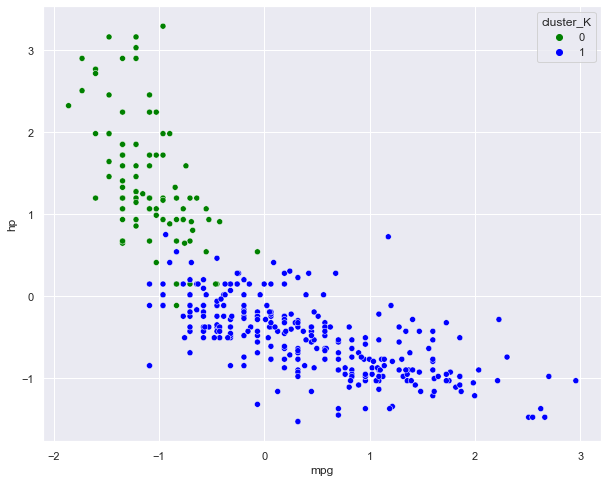

In [51]:
#plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="mpg", y="hp", hue="cluster_K",
              data=cc_z1, 
                    palette=['green','blue']);


In [52]:
carH.clusters_H.value_counts().sort_index()

1    100
2    298
Name: clusters_H, dtype: int64

In [53]:
carK.cluster_K.value_counts().sort_index()

0    105
1    293
Name: cluster_K, dtype: int64

In [54]:
carH.shape

(398, 14)

In [55]:
carK.shape

(398, 14)

In [56]:
car.head(20)

,cyl,yr,mpg,disp,hp,wt,acc,origin_america,origin_asia,origin_europe,mpg_level_high,mpg_level_low,mpg_level_medium
0,8,70,18.0,307.0,130.0,3504,12.0,1,0,0,0,0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1,0,0,0,1,0
2,8,70,18.0,318.0,150.0,3436,11.0,1,0,0,0,0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1,0,0,0,1,0
4,8,70,17.0,302.0,140.0,3449,10.5,1,0,0,0,0,1
5,8,70,15.0,429.0,198.0,4341,10.0,1,0,0,0,1,0
6,8,70,14.0,454.0,220.0,4354,9.0,1,0,0,0,1,0
7,8,70,14.0,440.0,215.0,4312,8.5,1,0,0,0,1,0
8,8,70,14.0,455.0,225.0,4425,10.0,1,0,0,0,1,0
9,8,70,15.0,390.0,190.0,3850,8.5,1,0,0,0,1,0


### Observation time! 

#### Mention how many optimal clusters are present in the data
- we can clearly see in both dendogram method and the elbow method, that the suggested cluster size is 2. 

#### what could be the possible reason behind it.
- looking at the final dataset, it is quite possible that the low mpg values are clubbed into 1 cluster and the high and medium mpg values are clubbed into another cluster. the same thing is visually seen in the dendogram, where a small subset of green cluster merges with the brown cluster and then there are 2 big clusters seen at the end.

##### How using different models for different clusters will be helpful in this case and how it will be different than using one single model without clustering? Mention how it impacts performance and prediction.

- after clustering if we find that there are 2 distinct cluster, 3 if i am being less choosy. now when we build 1 single model to predict the " whatever", i am mixing up guassians and hence the spread of the data will be too high, central value becomes less relaiable and can possibly cause outliers to exist, which will play a significant role in my model. hence building a separate model for seperate cluster is advisable to prevent the above.

## MLM Buliding

## Linear regression on the original dataset

In [57]:
X = car.drop(['mpg','origin_europe','mpg_level_low'], axis=1)
y = car[['mpg']]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [59]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [60]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.3975903270171246
The coefficient for yr is 0.46509729810545725
The coefficient for disp is 0.0074707554041114465
The coefficient for hp is 0.003188559606161445
The coefficient for wt is -0.00405398718110948
The coefficient for acc is 0.1415427193992852
The coefficient for origin_america is -1.6701407987853019
The coefficient for origin_asia is -0.6633536112854791
The coefficient for mpg_level_high is 9.029899699893399
The coefficient for mpg_level_medium is 1.7314216953437729


In [61]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -3.5943438132448122


In [62]:
regression_model.score(X_train, y_train)

0.8938226055158248

In [63]:
LRO = regression_model.score(X_test, y_test)
LRO

0.9099613879436991

## Linear regression on data with K means cluster

In [64]:
carK['cluster_K']=carK['cluster_K'].astype('category')
carK['cluster_K'] = carK['cluster_K'].replace({1: 'heavy', 0: 'light'})
carK = pd.get_dummies(carK, columns=['cluster_K'])

In [65]:
carK.head()

,cyl,yr,mpg,disp,hp,wt,acc,origin_america,origin_asia,origin_europe,mpg_level_high,mpg_level_low,mpg_level_medium,cluster_K_heavy,cluster_K_light
0,8,70,18.0,307.0,130.0,3504,12.0,1,0,0,0,0,1,0,1
1,8,70,15.0,350.0,165.0,3693,11.5,1,0,0,0,1,0,0,1
2,8,70,18.0,318.0,150.0,3436,11.0,1,0,0,0,0,1,0,1
3,8,70,16.0,304.0,150.0,3433,12.0,1,0,0,0,1,0,0,1
4,8,70,17.0,302.0,140.0,3449,10.5,1,0,0,0,0,1,0,1


In [66]:
X = carK.drop(['mpg','origin_europe','mpg_level_low','cluster_K_light'], axis=1)
y = carK[['mpg']]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [68]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [69]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.6296382169205511
The coefficient for yr is 0.4662873111183786
The coefficient for disp is 0.008886945297461589
The coefficient for hp is -0.002812102592784628
The coefficient for wt is -0.004020518892693464
The coefficient for acc is 0.16560097393078987
The coefficient for origin_america is -1.6314136259933636
The coefficient for origin_asia is -0.6113988563965986
The coefficient for mpg_level_high is 9.251080916669704
The coefficient for mpg_level_medium is 2.0813528714945484
The coefficient for cluster_K_heavy is -1.4061521471390934


In [70]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -1.7683496767449256


In [71]:
regression_model.score(X_train, y_train)

0.8947982152479076

In [72]:
KLR = regression_model.score(X_test, y_test)
KLR

0.9118863239875526

## Linear regression on data with H-clusters

In [73]:
carH['clusters_H']=carH['clusters_H'].astype('category')
carH['clusters_H'] = carH['clusters_H'].replace({1: 'heavy', 2: 'light'})
carH = pd.get_dummies(carH, columns=['clusters_H'])

In [74]:
X = carH.drop(['mpg','origin_europe','mpg_level_low','clusters_H_light'], axis=1)
y = carH[['mpg']]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [76]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

In [77]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cyl is -0.6759263712686528
The coefficient for yr is 0.4595008063783975
The coefficient for disp is 0.00914639614613408
The coefficient for hp is -0.004977351747196176
The coefficient for wt is -0.003972275933420739
The coefficient for acc is 0.16485914517170797
The coefficient for origin_america is -1.5988302725175154
The coefficient for origin_asia is -0.5901511512204496
The coefficient for mpg_level_high is 9.281744346370292
The coefficient for mpg_level_medium is 2.1204159227361665
The coefficient for clusters_H_heavy is 1.6231590928761146


In [78]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -2.460414810335241


In [79]:
regression_model.score(X_train, y_train)

0.8950074807714862

In [80]:
HLR = regression_model.score(X_test, y_test)
HLR

0.9119657052105086

In [81]:
modellists = []
modellists.append(['Linear Regression on Original Data set', LRO*100])
modellists.append(['Linear Regression with K means clusters', KLR*100])
modellists.append(['Linear Regression with Heirarchical clusters', HLR*100])
model_df = pd.DataFrame(modellists, columns = ['Model','r^2 on Test'])
model_df

,Model,r^2 on Test
0,Linear Regression on Original Data set,90.996139
1,Linear Regression with K means clusters,91.188632
2,Linear Regression with Heirarchical clusters,91.196571


### Improvisation/Suggestions

- Heirarchical clusters appears to explain the highest variation in the datset , very very slightly over the K-Means, but with a difference of less than 1% when compared with other models, to get more clarity a larger dataset may be needed.

- Since this is a dataset of used cars it doesn't give us how many previous owners has the cars seen which might be helpful variable, the reason/purpose that the cars were being used could also be an important factor which the dataset doesn't capture. these can play a significant role in understanding the drop/increase of mpg of a car that the company might be selling to some other customer

- With the above mentioned features it may be possible to get a higher accuracy or explainability of the models and its variables.


## Part 2/5

### DOMAIN:

Manufacturing
### CONTEXT:

Company X curates and packages wine across various vineyards spread throughout the country.
###  DATA DESCRIPTION:

The data concerns the chemical composition of the wine and its respective quality.
Attribute Information:

    A, B, C, D: specific chemical composition measure of the wine
    Quality: quality of wine [ Low and High ]

### PROJECT OBJECTIVE:

Goal is to build a synthetic data generation model using the existing data provided by the company.


In [82]:
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import train_test_split

In [83]:
wine = pd.ExcelFile('Part2 - Company.xlsx')
wine.sheet_names
wine = wine.parse('Sheet1')
wine.head()

,A,B,C,D,Quality
0,47,27,45,108,Quality A
1,174,133,134,166,Quality B
2,159,163,135,131,NaN
3,61,23,3,44,Quality A
4,59,60,9,68,Quality A


In [84]:
row, column = wine.shape
print('The dataset contains', row, 'rows and', column, 'columns')

The dataset contains 61 rows and 5 columns


In [85]:
#make a copy of the data
wi1 = wine.copy()

In [86]:
#dropping the target variable
wine = wine.drop('Quality',axis=1)

In [87]:
#checking for data types
wi1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   A        61 non-null     int64 
 1   B        61 non-null     int64 
 2   C        61 non-null     int64 
 3   D        61 non-null     int64 
 4   Quality  43 non-null     object
dtypes: int64(4), object(1)
memory usage: 2.5+ KB


In [88]:
# checking missing values in the copied dataset
wi1.isnull().sum()

A           0
B           0
C           0
D           0
Quality    18
dtype: int64

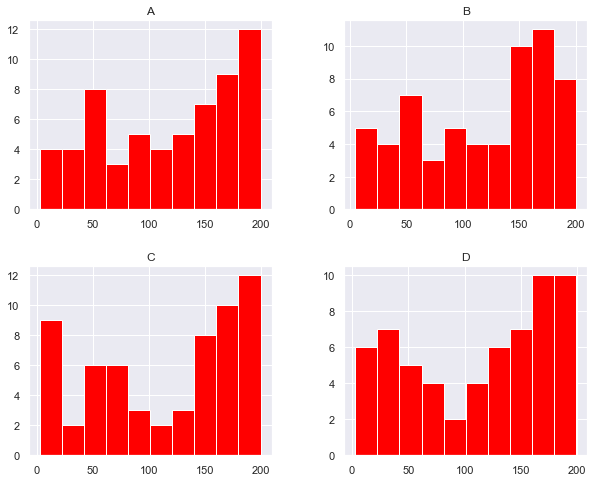

In [89]:
#checking the distribution of the data points
wine.hist(bins = 10, figsize = (10, 8), color = 'red')
plt.show()

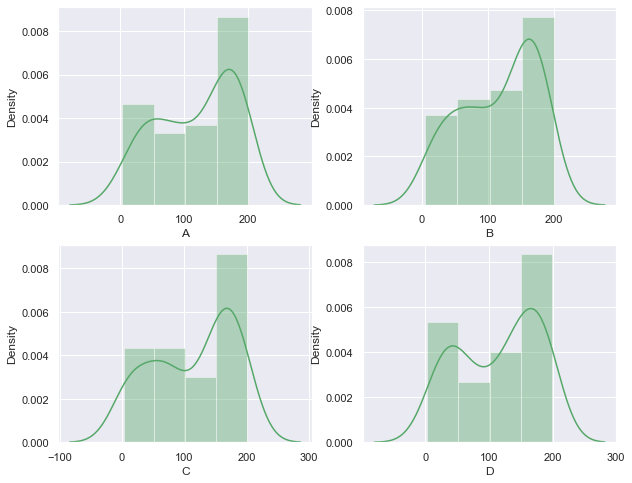

In [90]:
#checking for the density of the variable
plt.figure(figsize=(10, 8))
col = 1
for i in wine.columns:
    plt.subplot(2, 2, col)
    sns.distplot(wine[i], color = 'g')
    col += 1


###### the chemical compositions are on the same scales between 0 to 200

In [91]:
#scaling the numeric variables
w1 = wine.apply(zscore)
w1.head()

,A,B,C,D
0,-1.168034,-1.561080,-1.061569,-0.103138
1,0.904992,0.284923,0.306077,0.823013
2,0.660147,0.807376,0.321443,0.264129
3,-0.939512,-1.630740,-1.706975,-1.125099
4,-0.972158,-0.986381,-1.614775,-0.741864


In [92]:
wi1['Quality'].value_counts()

Quality A    26
Quality B    17
Name: Quality, dtype: int64

In [93]:
#applying kmeans with 2 centroids
k_means = KMeans(n_clusters = 2)
k_means.fit(w1)
labels = k_means.labels_

In [94]:
silhouette_score(w1,labels)

0.6891674125195145

In [95]:
#attaching the cluster labels to the original dataset
wi1["Quality_New"] = labels
wi1.head(5)

,A,B,C,D,Quality,Quality_New
0,47,27,45,108,Quality A,0
1,174,133,134,166,Quality B,1
2,159,163,135,131,NaN,1
3,61,23,3,44,Quality A,0
4,59,60,9,68,Quality A,0


In [96]:
#renaming the cluster labels
wi1['Quality_New'] = wi1['Quality_New'].replace({0: 'Quality A', 1: 'Quality B'})

In [97]:
wi1.dtypes

A               int64
B               int64
C               int64
D               int64
Quality        object
Quality_New    object
dtype: object

In [98]:
#dropping na rows
WineNew = wi1.dropna()

In [99]:
WineNew.shape

(43, 6)

In [100]:
#using the cluster labels and actual target labels to check for accuracy
pred = WineNew['Quality_New']
actual = WineNew['Quality']

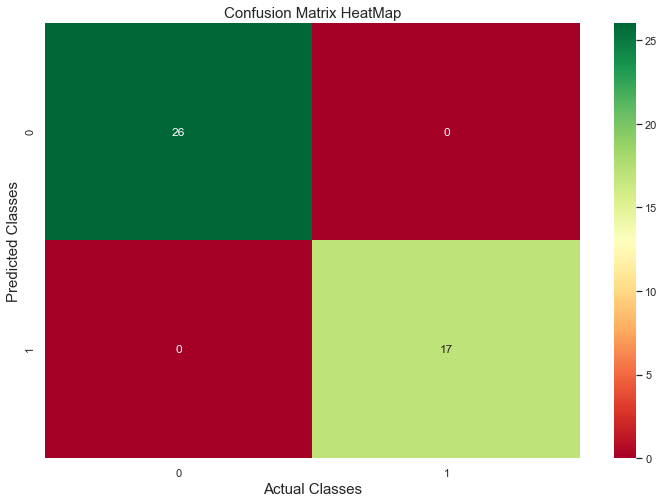

In [101]:
#visualization of confusion matrix in the form of a heatmap
cm = confusion_matrix(actual, pred)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix HeatMap', fontsize = 15);

### There appears to be no misclassification when checking the it with the non missing target variables and the predicted clusters, Hence the new labels can be used as a target variable

## Part 3/5


### DOMAIN:
 Automobile
 
### CONTEXT:
- The purpose is to classify a given silhouette as one of three types of vehicle, using a set of features extracted from the silhouette.The vehicle may be viewed from one of many different angles.


### DATA DESCRIPTION:
- The data contains features extracted from the silhouette of vehicles in different angles. Four "Corgie" model vehicles were used for the experiment: a double decker bus, Cheverolet van, Saab 9000 and an Opel Manta 400 cars. This particular combination of vehicles was chosen with the expectation that the bus, van and either one of the cars would be readily distinguishable, but it would be more difficult to distinguish between the cars.
- All the features are numeric i.e. geometric features extracted from the silhouette.


### PROJECT OBJECTIVE:
- Apply dimensionality reduction technique – PCA and train a model using principal components instead of training the model using just the raw data.


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,precision_recall_fscore_support
from sklearn import metrics


### Data

In [103]:
vehicle = pd.read_csv('Part3 - vehicle.csv')
vehicle.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [104]:
rows, column = vehicle.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 846 rows and 19 columns.


In [105]:
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

In [106]:
print('Duplicated rows: ', vehicle[vehicle.duplicated()].shape[0])

Duplicated rows:  0


In [107]:
vehicle.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

##### There appears to be quite a few missing values. we will replace them with median now

In [108]:
for cols in vehicle.columns:
    if(cols != 'class'): 
        vehicle[cols] = vehicle[cols].fillna(vehicle[cols].median())

In [109]:
vehicle.describe().T

,count,mean,std,min,25%,50%,75%,max
compactness,846.0,93.678487,8.234474,73.0,87.00,93.0,100.00,119.0
circularity,846.0,44.823877,6.134272,33.0,40.00,44.0,49.00,59.0
distance_circularity,846.0,82.100473,15.741569,40.0,70.00,80.0,98.00,112.0
radius_ratio,846.0,168.874704,33.401356,104.0,141.00,167.0,195.00,333.0
pr.axis_aspect_ratio,846.0,61.677305,7.882188,47.0,57.00,61.0,65.00,138.0
max.length_aspect_ratio,846.0,8.567376,4.601217,2.0,7.00,8.0,10.00,55.0
scatter_ratio,846.0,168.887707,33.197710,112.0,147.00,157.0,198.00,265.0
elongatedness,846.0,40.936170,7.811882,26.0,33.00,43.0,46.00,61.0
pr.axis_rectangularity,846.0,20.580378,2.588558,17.0,19.00,20.0,23.00,29.0
max.length_rectangularity,846.0,147.998818,14.515652,118.0,137.00,146.0,159.00,188.0


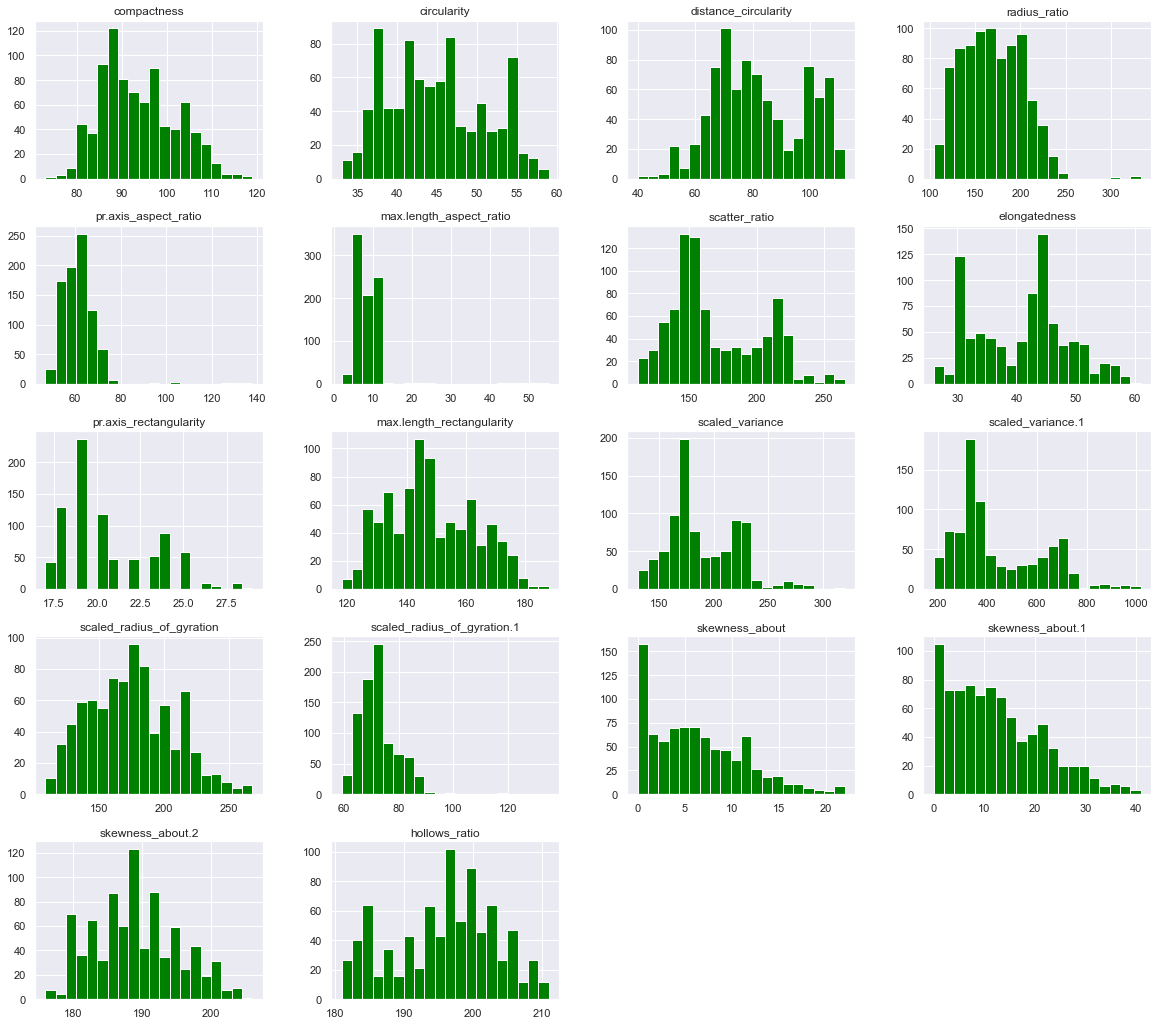

In [110]:
#plotting the distribution of the numerical variables

vehicle.hist(bins = 20, figsize = (20, 18), color = 'green')
plt.show()

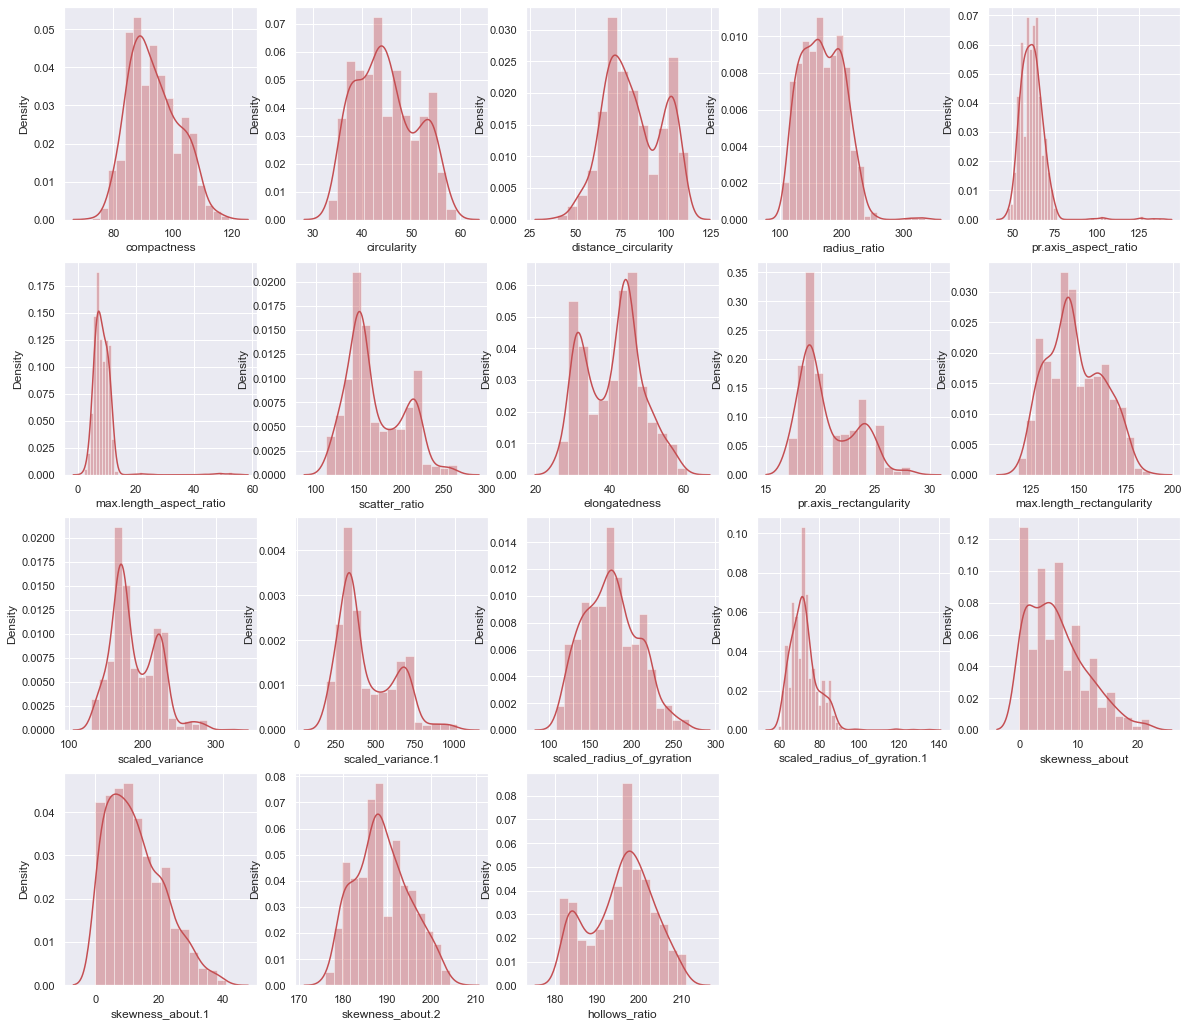

In [111]:
#Density plots
plt.figure(figsize=(20, 18))
col = 1
for i in vehicle.drop(columns='class').columns:
    plt.subplot(4, 5, col)
    sns.distplot(vehicle[i], color = 'r')
    col += 1

Columns have data distributed across multiple scales. Several columns have distributions that are not unimodal (eg.: distance_circularity, hollows_ratio, elongatedness Column skweness_about, skewness_about 1 have data that is right skewed whereas for column skewness_about 2 data is nearly normally distributed 

Some columns have long right tail (eg.: pr.axis_aspect_ratio) as evident from the above distplot it is highly likely that they will have outliers

car    429
bus    218
van    199
Name: class, dtype: int64


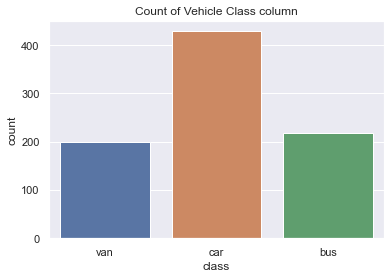

In [112]:
#checking the distribution of the class variable

print(vehicle['class'].value_counts())
plt.title('Count of Vehicle Class column')
sns.countplot(x = 'class', data = vehicle);

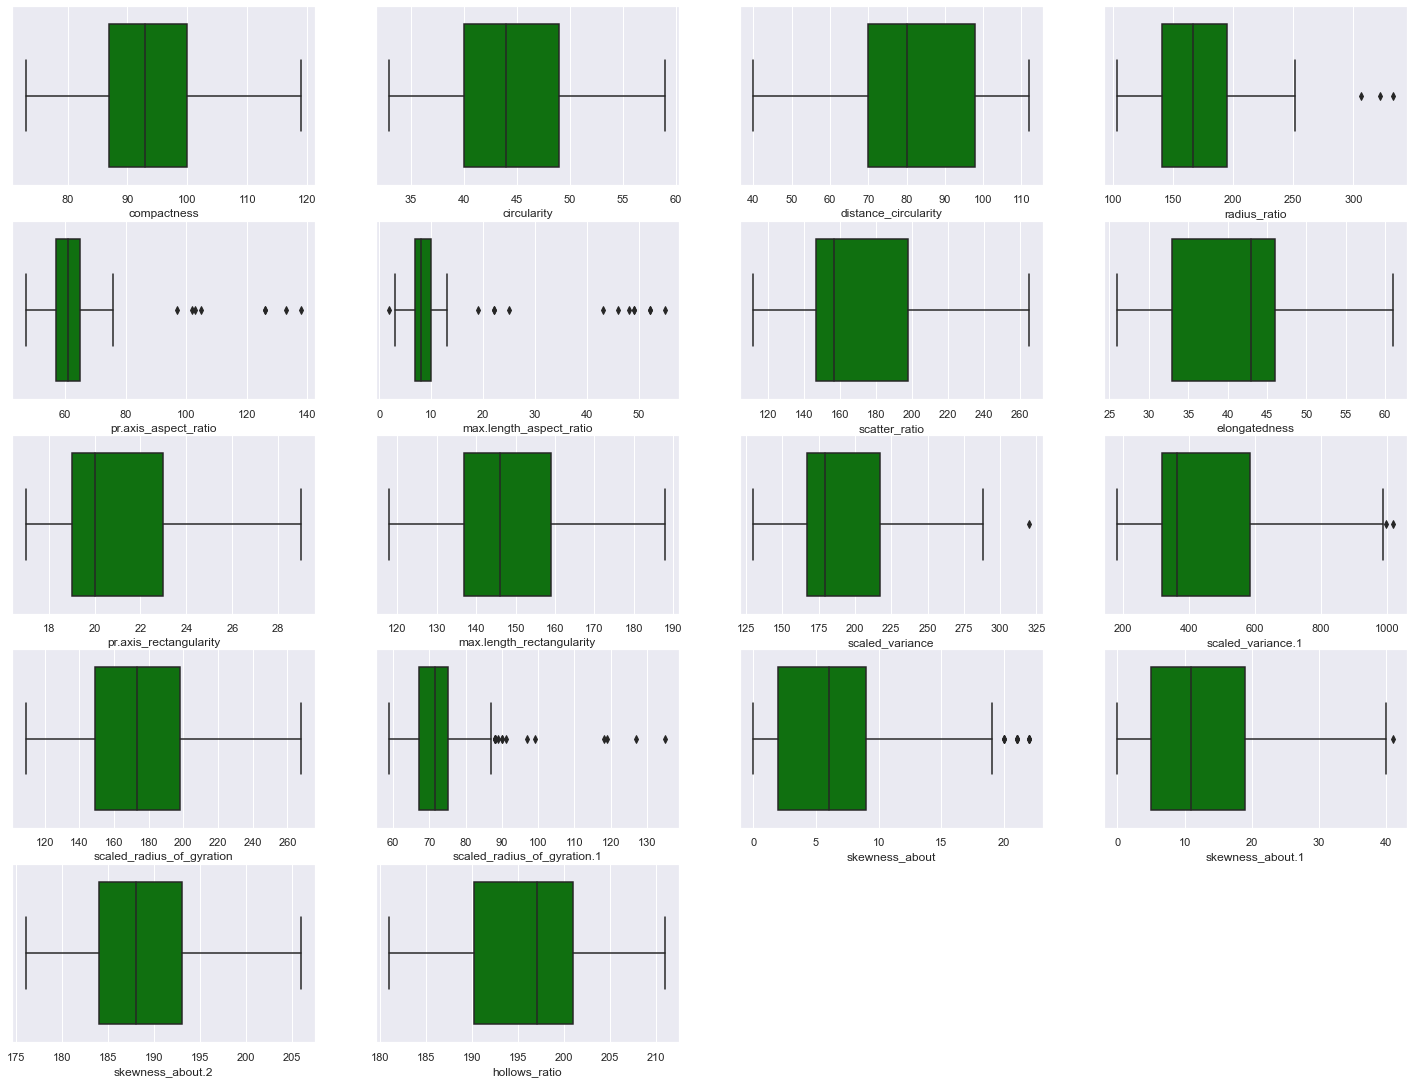

In [113]:
#boxplots for outliers
plt.figure(figsize = (25,23))
col = 1
for i in vehicle.drop(columns = 'class').columns:
    plt.subplot(6, 4, col)
    sns.boxplot(vehicle[i],color = 'green')
    col += 1

Above Boxplots reveal that there are outliers in 8 different columns., will have them treated eventually

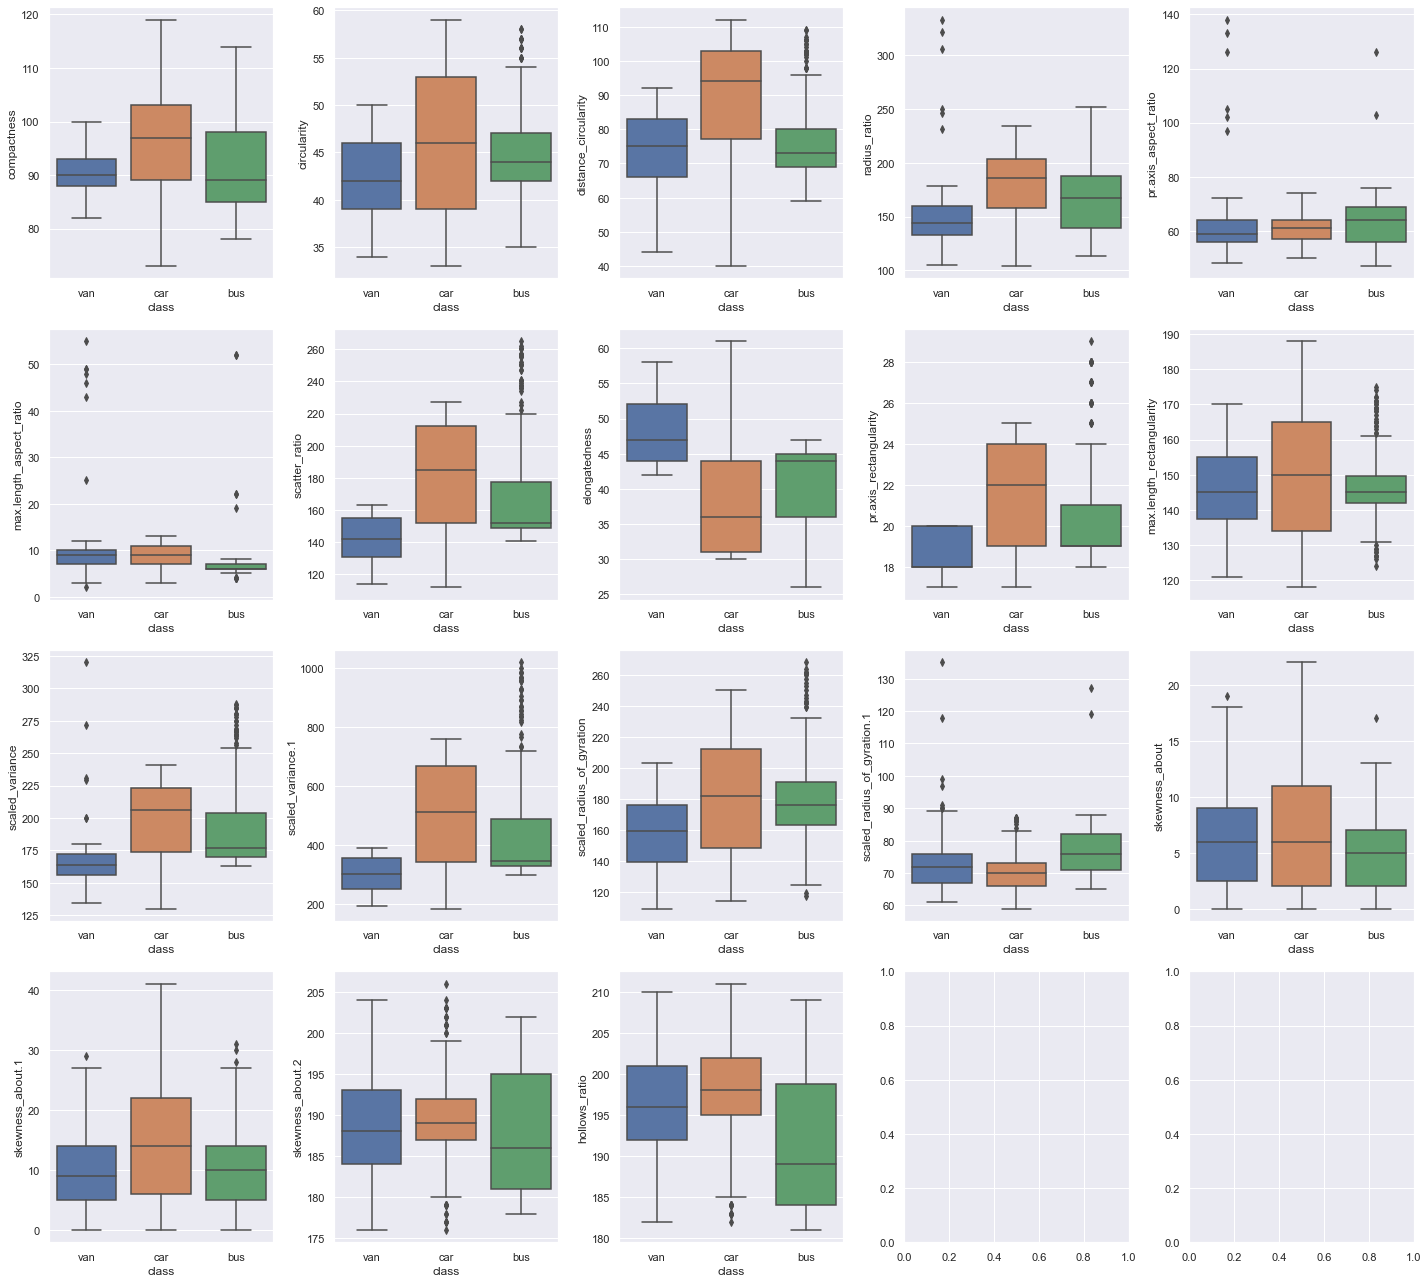

In [114]:
#Boxplots against the class with other numeric variables
fig,axs = plt.subplots(4,5,figsize=(20,18))
sns.boxplot(x = "class", y = "compactness",data = vehicle,ax = axs[0,0]);
sns.boxplot(x = "class", y = "circularity",data = vehicle,ax = axs[0,1]);
sns.boxplot(x = "class", y = "distance_circularity",data = vehicle,ax = axs[0,2]);
sns.boxplot(x = "class", y = "radius_ratio",data = vehicle,ax = axs[0,3]);
sns.boxplot(x = "class", y = "pr.axis_aspect_ratio",data = vehicle,ax = axs[0,4]);
sns.boxplot(x = "class", y = "max.length_aspect_ratio",data = vehicle,ax = axs[1,0]);
sns.boxplot(x = "class", y = "scatter_ratio",data = vehicle,ax = axs[1,1]);
sns.boxplot(x = "class", y = "elongatedness",data = vehicle,ax = axs[1,2]);
sns.boxplot(x = "class", y = "pr.axis_rectangularity",data = vehicle,ax = axs[1,3]);
sns.boxplot(x = "class", y = "max.length_rectangularity",data = vehicle,ax = axs[1,4]);
sns.boxplot(x = "class", y = "scaled_variance",data = vehicle,ax = axs[2,0]);
sns.boxplot(x = "class", y = "scaled_variance.1",data = vehicle,ax = axs[2,1]);
sns.boxplot(x = "class", y = "scaled_radius_of_gyration",data = vehicle,ax = axs[2,2]);
sns.boxplot(x = "class", y = "scaled_radius_of_gyration.1",data = vehicle,ax = axs[2,3]);
sns.boxplot(x = "class", y = "skewness_about",data = vehicle,ax = axs[2,4]);
sns.boxplot(x = "class", y = "skewness_about.1",data = vehicle,ax = axs[3,0]);
sns.boxplot(x = "class", y = "skewness_about.2",data = vehicle,ax = axs[3,1]);
sns.boxplot(x = "class", y = "hollows_ratio",data = vehicle,ax = axs[3,2]);
fig.tight_layout()

There is significant difference between classes when compared with the mean and median with all the numeric attributes

### outlier treatment! 

In [115]:
for col_name in vehicle.drop(columns = 'class').columns:
    q1 = vehicle[col_name].quantile(0.25)
    q3 = vehicle[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    
    vehicle.loc[(vehicle[col_name] < low) | (vehicle[col_name] > high), col_name] = vehicle[col_name].median()

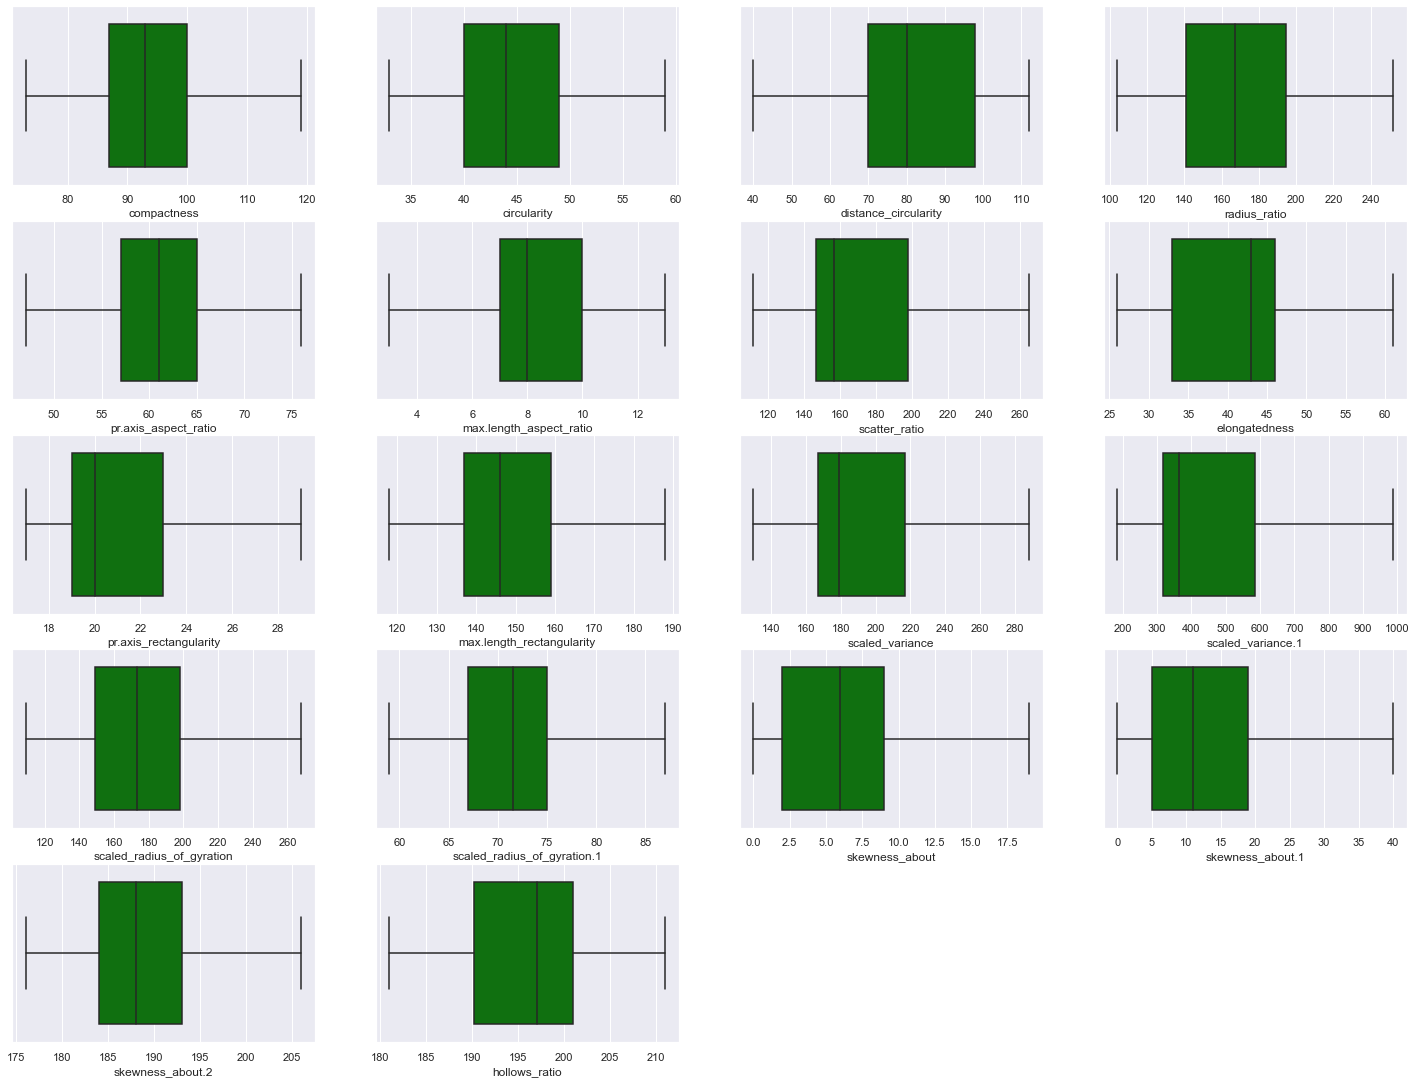

In [116]:
#boxplot after outlier treatment

plt.figure(figsize = (25,23))
col = 1
for i in vehicle.drop(columns ='class').columns:
    plt.subplot(6, 4, col)
    sns.boxplot(vehicle[i],color ='green')
    col += 1


much better!!

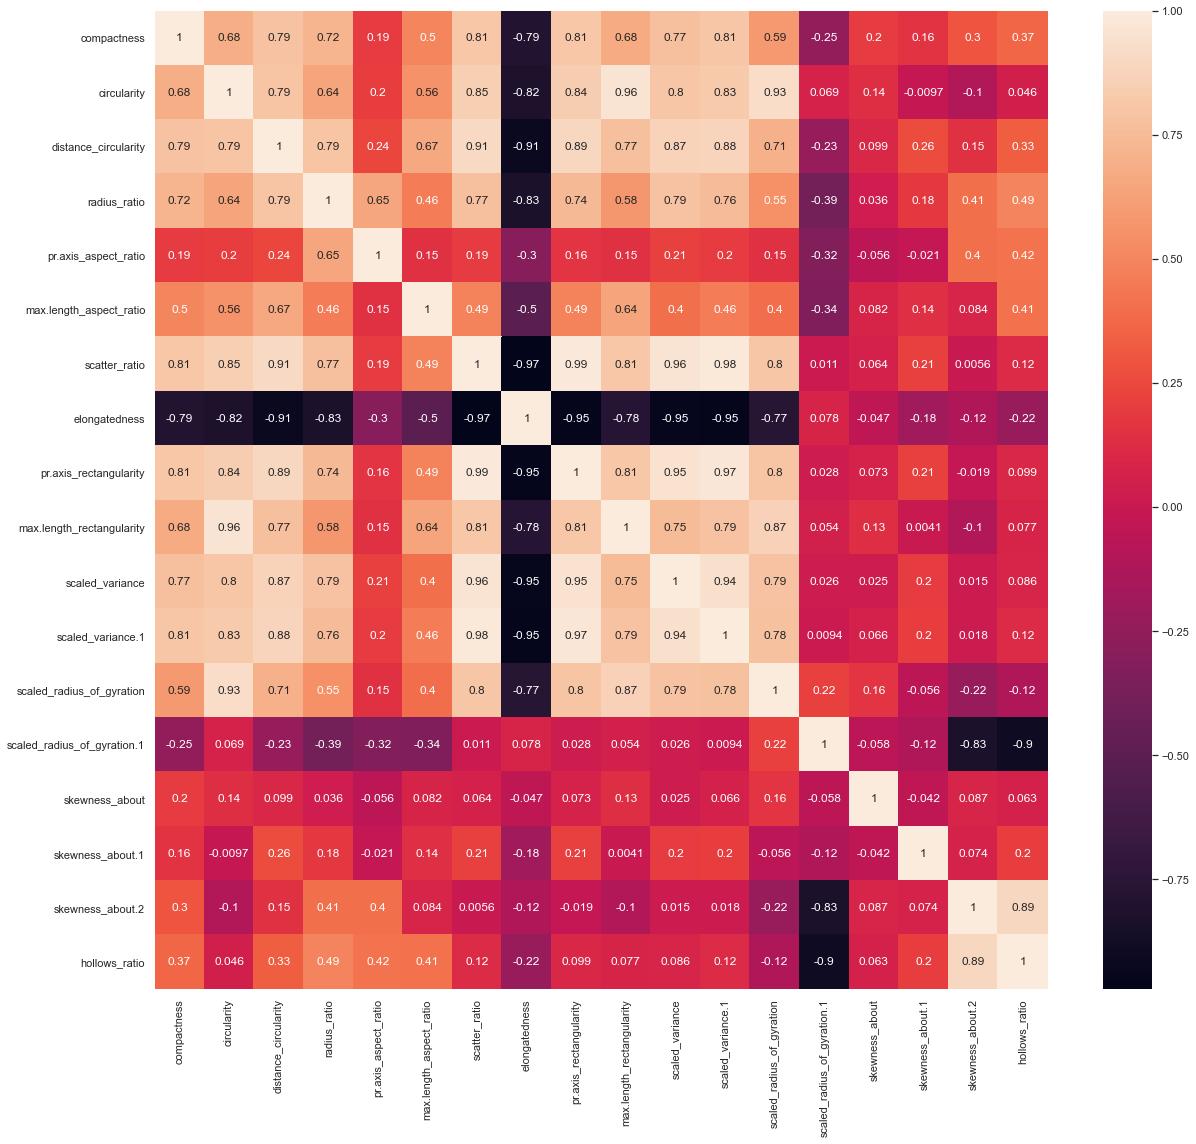

In [117]:
#checking for correlation

plt.figure(figsize = (20,18))
corr = vehicle.corr()
sns.heatmap(corr,annot = True);

In [118]:
#spliiting the data to check for correlation with the class variable

X = vehicle.loc[:, vehicle.columns != 'class']
y = vehicle['class'].astype('category').cat.codes

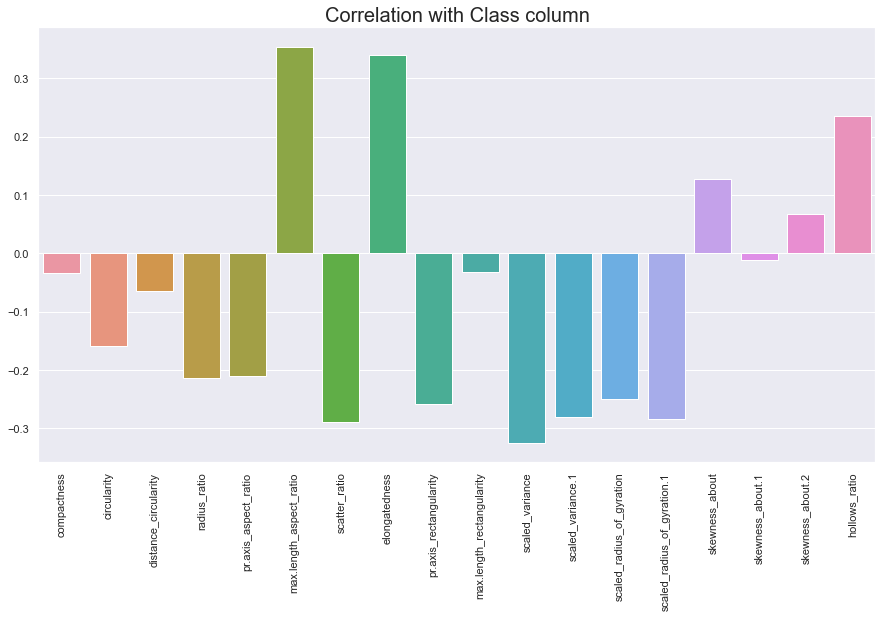

In [119]:
#plotting the correlation with target variable


plt.figure(figsize = (15, 8))
ax = sns.barplot(x = X.columns, y = X.corrwith(y))
sns.barplot(x = X.columns, y = X.corrwith(y))

plt.title('Correlation with Class column', fontsize = 20)
x = plt.setp(ax.get_xticklabels(), rotation = 90)

### Performing dimensionality reduction before fitting a SVM , but will do a compare between them post PCA is complete.

## PCA/ Dimensionality Reduction

In [120]:
#scaling the numerical variables

XScaled = X.apply(zscore)
XScaled.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio
0,0.160580,0.518073,0.057177,0.300945,1.933135,0.912212,-0.207598,0.136262,-0.224342,0.758332,-0.400771,-0.337407,0.285705,-0.315806,-0.032330,0.387162,-0.312012,0.183957
1,-0.325470,-0.623732,0.120741,-0.850666,-0.740596,0.427456,-0.599423,0.520519,-0.610886,-0.344578,-0.594220,-0.618623,-0.513630,0.009122,0.624090,0.161740,0.013265,0.452977
2,1.254193,0.844303,1.519141,1.265808,0.863642,0.912212,1.148719,-1.144597,0.935290,0.689401,1.114582,1.131806,1.392477,0.171586,1.718123,-0.401818,-0.149374,0.049447
3,-0.082445,-0.623732,-0.006386,-0.290423,0.328896,0.427456,-0.750125,0.648605,-0.610886,-0.344578,-0.916635,-0.739145,-1.466683,-1.453054,-0.032330,-0.289106,1.639649,1.529056
4,-1.054545,-0.134387,-0.769150,1.141310,-0.027601,-0.057300,-0.599423,0.520519,-0.610886,-0.275646,1.694930,-0.647319,0.408680,-0.072110,0.624090,-0.176395,-1.450481,-1.699181


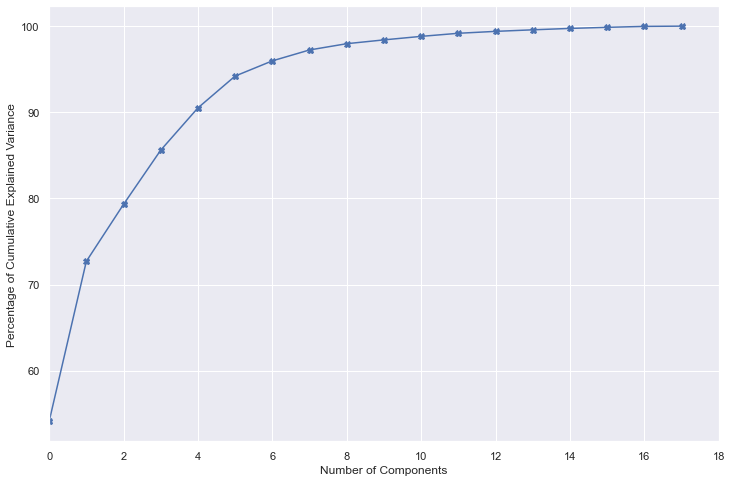

In [121]:
#plotting the cumulative variance explained by the principal components
pca = PCA()
X_pca_ = pca.fit_transform(XScaled)
plt.figure(figsize = (12, 8))
plt.plot((np.cumsum(pca.explained_variance_ratio_) * 100), marker = 'X')
plt.xlim(0, 18)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Cumulative Explained Variance');

In [122]:
print(pca.explained_variance_)

[9.74940269e+00 3.35071912e+00 1.19238155e+00 1.13381916e+00
 8.83997312e-01 6.66265745e-01 3.18150910e-01 2.28179142e-01
 1.31018595e-01 7.98619108e-02 7.33979478e-02 6.46162669e-02
 4.01448646e-02 3.22758478e-02 2.93936408e-02 2.27005257e-02
 1.98136761e-02 5.16287320e-03]


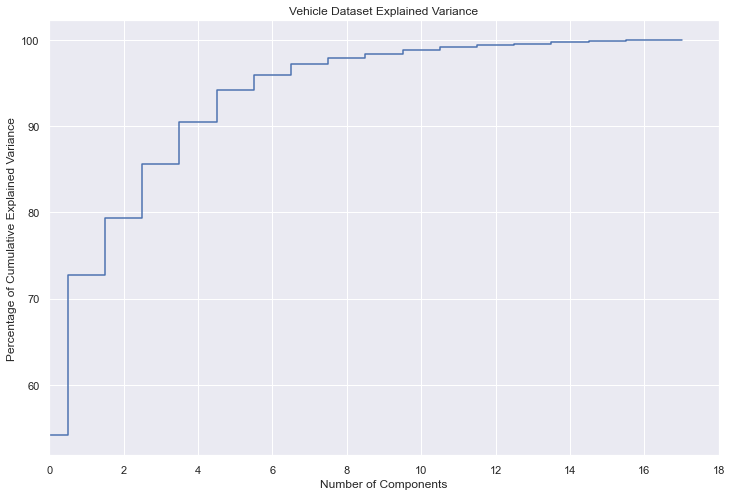

In [123]:
plt.figure(figsize = (12, 8))
plt.step(list(range(18)), (np.cumsum(pca.explained_variance_ratio_) * 100), where = 'mid')
plt.xlim(0, 18)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of Cumulative Explained Variance')
plt.title('Vehicle Dataset Explained Variance');

We can see that the first six components explain more than 95% of variation. Between first 5 components, more than 91% of the information is captured. The above plot shows almost 95% variance by the first 6 components. Therefore we can drop 7th component onwards.

In [124]:
#Using 6 components and printing the eigen vectors
pca3 = PCA(n_components = 6)
pca3.fit(XScaled)
print(pca3.components_)
print(pca3.explained_variance_ratio_)
Xpca3 = pca3.transform(XScaled)

[[ 0.27250289  0.28725469  0.30242111  0.26971354  0.09786073  0.19520014
   0.31052393 -0.3090069   0.307287    0.27815416  0.29976509  0.30553237
   0.26323762 -0.04193594  0.03608321  0.05872048  0.03801314  0.08474   ]
 [-0.08704358  0.13162176 -0.04614301 -0.19793126 -0.25783995 -0.10804563
   0.07528535 -0.01322994  0.0875602   0.12215424  0.07726575  0.07150302
   0.21058205  0.50362158 -0.01576632 -0.09274624 -0.50162122 -0.50761211]
 [-0.03818521 -0.20114691  0.06346211  0.05628517 -0.06199275 -0.14895782
   0.10904283 -0.09085269  0.1060705  -0.21368469  0.14459981  0.11034373
  -0.20287019  0.07386402 -0.55917399  0.6706805  -0.06224071 -0.04170535]
 [ 0.13867501 -0.03805548  0.10895429 -0.25435509 -0.61276572  0.27867816
   0.00539295  0.06521486  0.03089915  0.04146747 -0.06400509 -0.00219687
  -0.08553965 -0.11539962  0.47370331  0.42842603 -0.0274096   0.09603749]
 [ 0.13710146 -0.13899557 -0.08001743  0.13374437  0.12360146 -0.63489336
   0.08555745 -0.07907344  0.08164

In [125]:
#printing the original features and the reduced features
pca_6 = PCA(n_components = 6)
X_pca = pca_6.fit_transform(XScaled)
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 18
Reduced number of features: 6


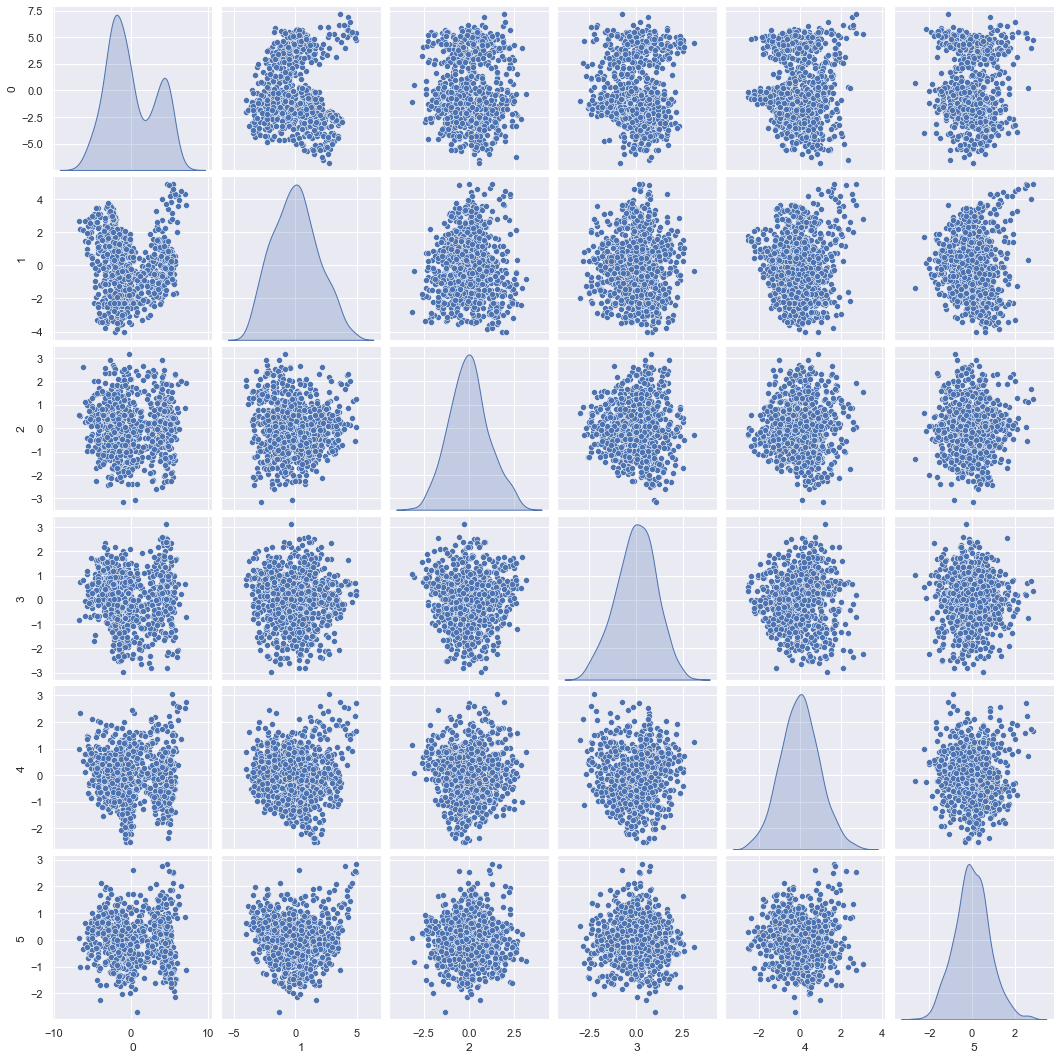

In [126]:
# Make a pairplot now
pca_df = pd.DataFrame(data = X_pca)
pca_df.head()
sns.pairplot(pca_df, diag_kind = 'kde');

## SVM on Original Dataset

In [127]:
X_train, X_test, y_train, y_test = train_test_split(XScaled, y, test_size = 0.3, random_state = 42)

In [128]:
X_train.shape

(592, 18)

In [129]:
X_test.shape

(254, 18)

In [130]:
# Building a Support Vector Machine on train data
svc_model = SVC(C = 4, kernel = 'rbf', gamma = 'scale')
svc_model.fit(X_train, y_train)

SVC(C=4)

In [131]:
sv_train_predict = svc_model .predict(X_train)
print("Model Accuracy on train: {0:.4f}".format(metrics.accuracy_score(y_train, sv_train_predict)))
print()

Model Accuracy on train: 0.9916



In [132]:
#predicting on test data

sv_test_predict = svc_model .predict(X_test)
print("Model Accuracy on test: {0:.4f}".format(metrics.accuracy_score(y_test, sv_test_predict)))
print()

Model Accuracy on test: 0.9843



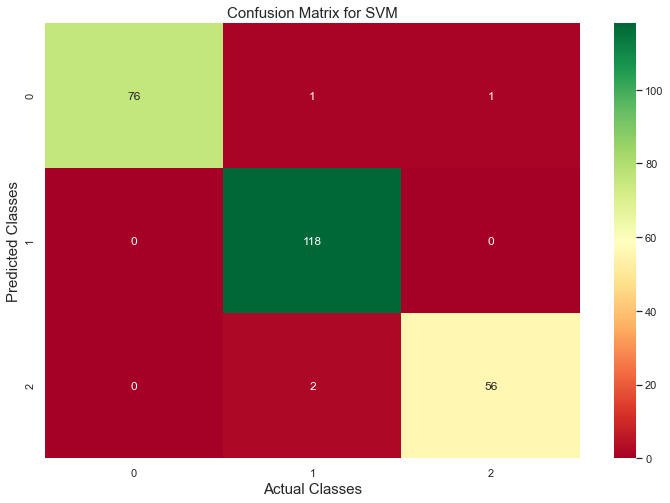

In [133]:
#visualization of confusion matrix in the form of a heatmap

cm = confusion_matrix(y_test, sv_test_predict)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVM', fontsize = 15);

In [134]:
#printing classification report

print("Classification Report")
print(metrics.classification_report(y_test, sv_test_predict, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        78
           1       0.98      1.00      0.99       118
           2       0.98      0.97      0.97        58

    accuracy                           0.98       254
   macro avg       0.99      0.98      0.98       254
weighted avg       0.98      0.98      0.98       254



In [135]:
precision_SV, recall_SV, f1_score_SV, support = precision_recall_fscore_support(y_test, sv_test_predict, average = 'macro')
print('Precision Score :', '%0.2f' % precision_SV)
print('Recall Score :', '%0.2f' % recall_SV)
print('F1-Score:', '%0.2f' % f1_score_SV)
SV_Acc = accuracy_score(y_test, sv_test_predict)
print('Accuracy Score :','%0.2f' % SV_Acc)

Precision Score : 0.99
Recall Score : 0.98
F1-Score: 0.98
Accuracy Score : 0.98


## SVM on PCA Dataset

In [136]:
X_tr, X_te, y_tr, y_te = train_test_split(X_pca, y, test_size = 0.3, random_state = 42)

In [137]:
X_tr.shape

(592, 6)

In [138]:
X_te.shape

(254, 6)

In [139]:
svc_model_pca = SVC(C = 4, kernel = 'rbf', gamma = 'scale')
svc_model_pca.fit(X_tr, y_tr)

SVC(C=4)

In [140]:
#predicting on train data
sv_tr_predict = svc_model_pca .predict(X_tr)
print("Model Accuracy on train: {0:.4f}".format(metrics.accuracy_score(y_tr, sv_tr_predict)))
print()

Model Accuracy on train: 0.9459



In [141]:
#predicting on test data
sv_te_predict = svc_model_pca .predict(X_te)
print("Model Accuracy on test: {0:.4f}".format(metrics.accuracy_score(y_te, sv_te_predict)))
print()

Model Accuracy on test: 0.9252



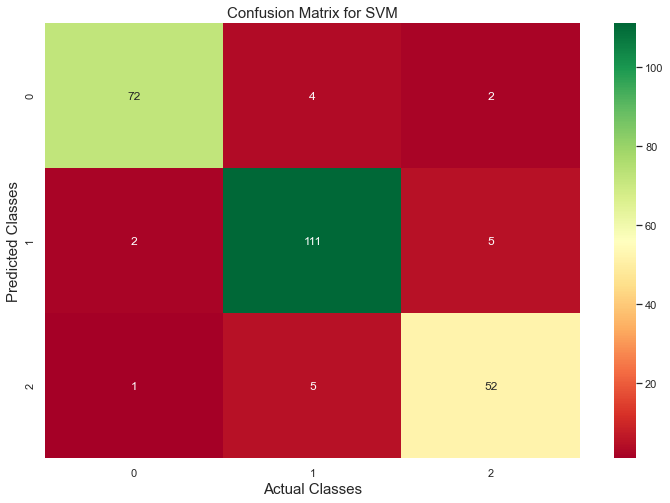

In [142]:
#visualization of confusion matrix in the form of a heatmap
cm= confusion_matrix(y_te, sv_te_predict)
plt.figure(figsize = (12, 8))
sns.heatmap(cm, annot = True, cmap = 'RdYlGn', fmt = 'd')
plt.xlabel('Actual Classes', fontsize = 15)
plt.ylabel('Predicted Classes', fontsize = 15)
plt.title('Confusion Matrix for SVM', fontsize = 15);



In [143]:
#printing classification report
print("Classification Report")
print(metrics.classification_report(y_te, sv_te_predict, labels=[0,1,2]))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        78
           1       0.93      0.94      0.93       118
           2       0.88      0.90      0.89        58

    accuracy                           0.93       254
   macro avg       0.92      0.92      0.92       254
weighted avg       0.93      0.93      0.93       254



In [144]:
precision_SV_pca, recall_SV_pca, f1_score_SV_pca, support_pca = precision_recall_fscore_support(y_te, sv_te_predict,average='macro')
print('Precision Score :', '%0.2f' % precision_SV_pca)
print('Recall Score :', '%0.2f' % recall_SV_pca)
print('F1-Score:', '%0.2f' % f1_score_SV_pca)
SV_Acc_pca= accuracy_score(y_te, sv_te_predict)
print('Accuracy Score :','%0.2f' % SV_Acc_pca)

Precision Score : 0.92
Recall Score : 0.92
F1-Score: 0.92
Accuracy Score : 0.93


In [145]:
modellists = []
modellists.append(['Support Vector Classifier without PCA', SV_Acc * 100, recall_SV * 100, precision_SV * 100,f1_score_SV*100])
modellists.append(['Support Vector Classifier with PCA', SV_Acc_pca* 100, recall_SV_pca * 100, precision_SV_pca * 100,f1_score_SV_pca*100])
model_df = pd.DataFrame(modellists, columns = ['Model','Accuracy Score of Test Data', 'Recall Score', 'Precision Score','F1 Score'])
model_df

,Model,Accuracy Score of Test Data,Recall Score,Precision Score,F1 Score
0,Support Vector Classifier without PCA,98.425197,97.995874,98.588758,98.279124
1,Support Vector Classifier with PCA,92.519685,92.010220,92.211864,92.094616


## Summary/Conclusion

Both the model gives more than 90% accuracy on the test data, However, PCA used only 6 attributes to come up with an accuracy of 90%+ where as the model with Original Data used all the variables (18 columns) to come up with 90%+ accuracy, the difference can be illustrated even better if the dataset had been cursed with dimensionality.

## Part 4/5


### DOMAIN:
Sports management


### CONTEXT:
Company X is a sports management company for international cricket.


### DATA DESCRIPTION:
The data is collected belongs to batsman from IPL series conducted so far. Attribute Information:

    Runs: Runs score by the batsman
    Ave: Average runs scored by the batsman per match
    SR: strike rate of the batsman
    Fours: number of boundary/four scored
    Six: number of boundary/six scored
    HF: number of half centuries scored so far

### PROJECT OBJECTIVE:
Goal is to build a data driven batsman ranking model for the sports management company to make business decisions.

In [146]:
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from scipy.stats import zscore
from sklearn.metrics import silhouette_samples, silhouette_score

In [147]:
ipl=pd.read_csv('Part4 - batting_bowling_ipl_bat.csv')
ipl=ipl.dropna(axis=0)
ipl.head()

,Name,Runs,Ave,SR,Fours,Sixes,HF
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0
5,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0
7,CL White,479.0,43.54,149.68,41.0,20.0,5.0
9,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0


In [148]:
rows, column = ipl.shape
print('The dataset contains', rows, 'rows and', column, 'columns.')

The dataset contains 90 rows and 7 columns.


In [149]:
ipl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 1 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Name    90 non-null     object 
 1   Runs    90 non-null     float64
 2   Ave     90 non-null     float64
 3   SR      90 non-null     float64
 4   Fours   90 non-null     float64
 5   Sixes   90 non-null     float64
 6   HF      90 non-null     float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


In [150]:
ipl.describe().T

,count,mean,std,min,25%,50%,75%,max
Runs,90.0,219.933333,156.253669,2.00,98.000,196.500,330.7500,733.00
Ave,90.0,24.729889,13.619215,0.50,14.665,24.440,32.1950,81.33
SR,90.0,119.164111,23.656547,18.18,108.745,120.135,131.9975,164.10
Fours,90.0,19.788889,16.399845,0.00,6.250,16.000,28.0000,73.00
Sixes,90.0,7.577778,8.001373,0.00,3.000,6.000,10.0000,59.00
HF,90.0,1.188889,1.688656,0.00,0.000,0.500,2.0000,9.00


In [151]:
print('Duplicated rows: ', ipl[ipl.duplicated()].shape[0])

Duplicated rows:  0


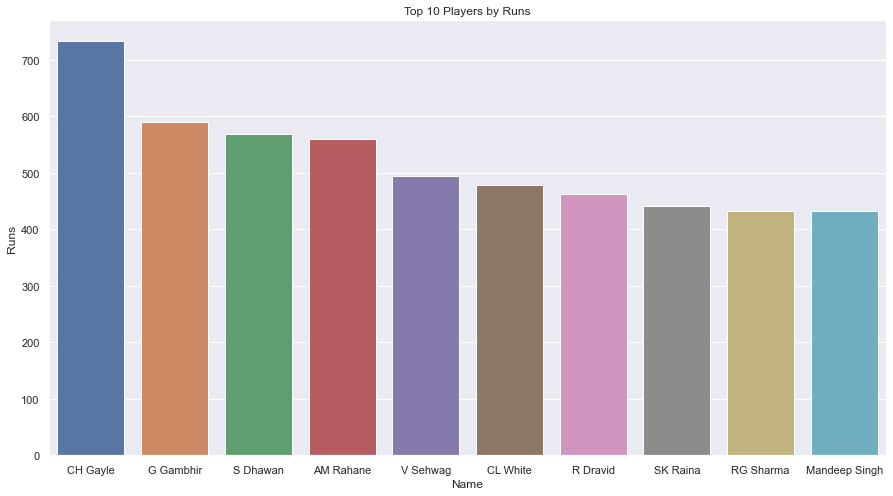

In [152]:
plt.figure(figsize = (15,8))
b1 = ipl.groupby('Name')['Runs'].sum().sort_values(ascending = False ).head(10)
b1 = b1.reset_index() 
b1.columns = ['Name' ,'Runs']
sns.barplot(data = b1 , x = 'Name' , y ='Runs');
plt.title("Top 10 Players by Runs");

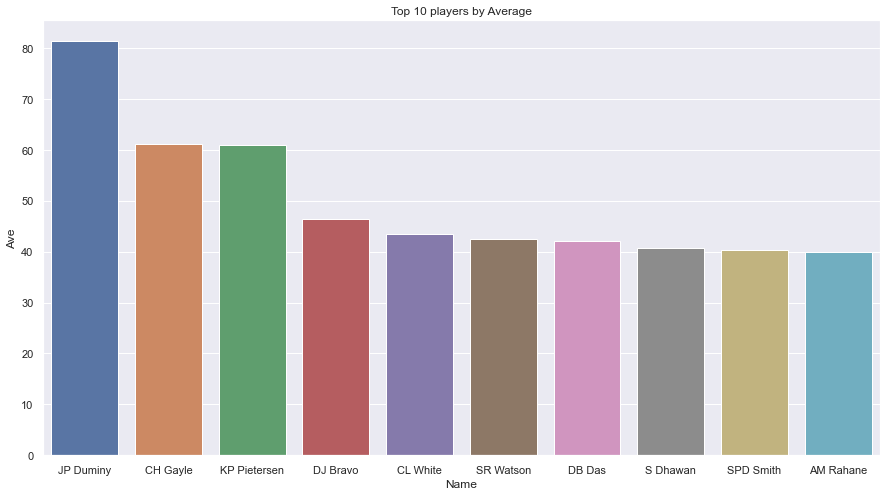

In [153]:
plt.figure(figsize = (15,8))
b1 = ipl.groupby('Name')['Ave'].sum().sort_values(ascending = False ).head(10)
b1 = b1.reset_index() 
b1.columns = ['Name' ,'Ave']
sns.barplot(data = b1 , x = 'Name' , y ='Ave')
plt.title("Top 10 players by Average");

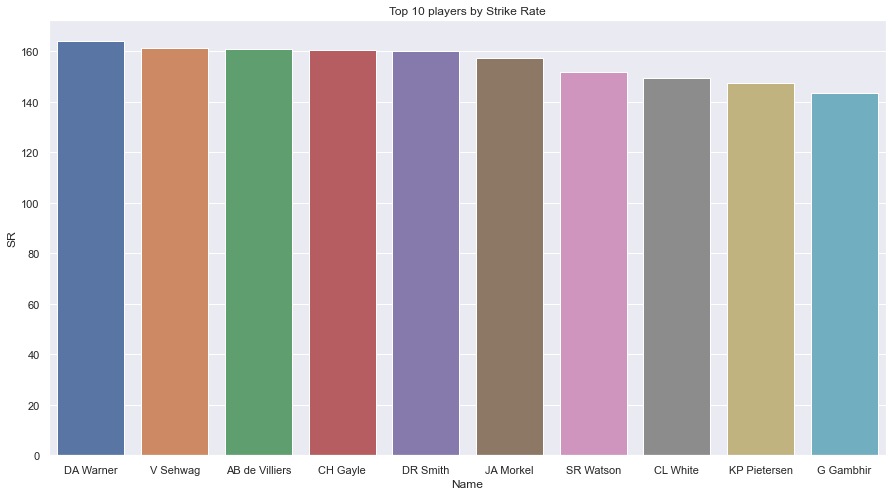

In [154]:
plt.figure(figsize = (15,8))
b1 = ipl.groupby('Name')['SR'].sum().sort_values(ascending = False ).head(10)
b1 = b1.reset_index() 
b1.columns = ['Name' ,'SR']
sns.barplot(data = b1 , x = 'Name' , y ='SR')
plt.title("Top 10 players by Strike Rate");

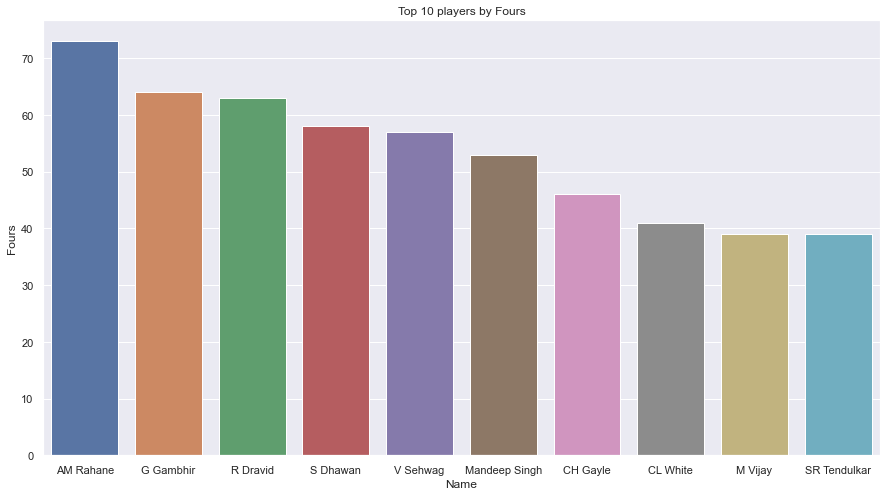

In [155]:
plt.figure(figsize = (15,8))
b1 = ipl.groupby('Name')['Fours'].sum().sort_values(ascending = False ).head(10)
b1= b1.reset_index() 
b1.columns = ['Name' ,'Fours']
sns.barplot(data = b1 , x = 'Name' , y ='Fours')
plt.title("Top 10 players by Fours");

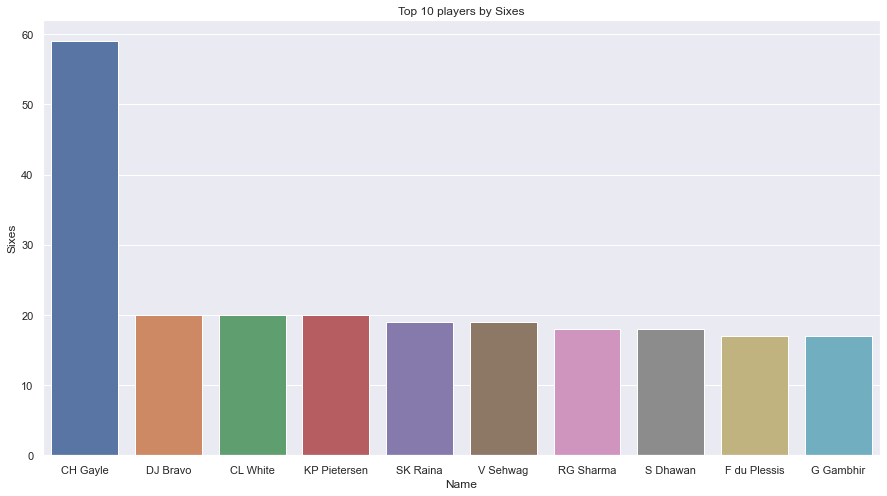

In [156]:
plt.figure(figsize = (15,8))
b1 = ipl.groupby('Name')['Sixes'].sum().sort_values(ascending = False ).head(10)
b1 = b1.reset_index() 
b1.columns = ['Name' ,'Sixes']
sns.barplot(data = b1 , x = 'Name' , y ='Sixes')
plt.title("Top 10 players by Sixes");

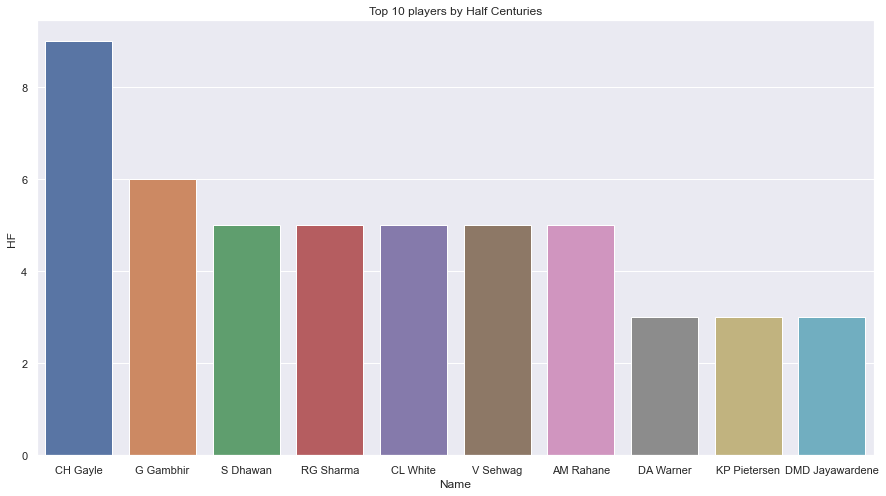

In [157]:
plt.figure(figsize = (15,8))
b1 = ipl.groupby('Name')['HF'].sum().sort_values(ascending = False ).head(10)
b1 = b1.reset_index() 
b1.columns = ['Name' ,'HF']
sns.barplot(data = b1 , x = 'Name' , y ='HF')
plt.title("Top 10 players by Half Centuries");

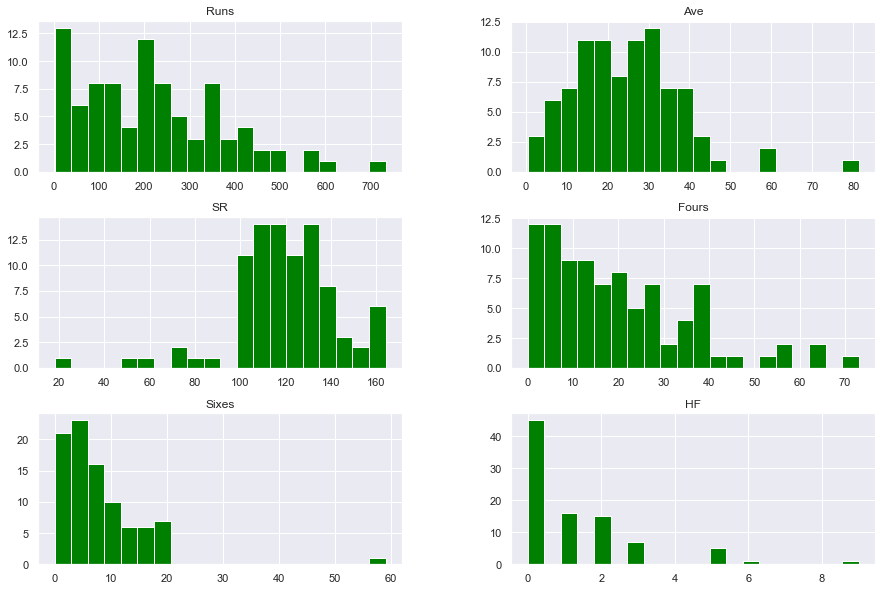

In [158]:
# Plotting numerical values

ipl.hist(bins = 20, figsize = (15, 10), color = 'green')
plt.show()

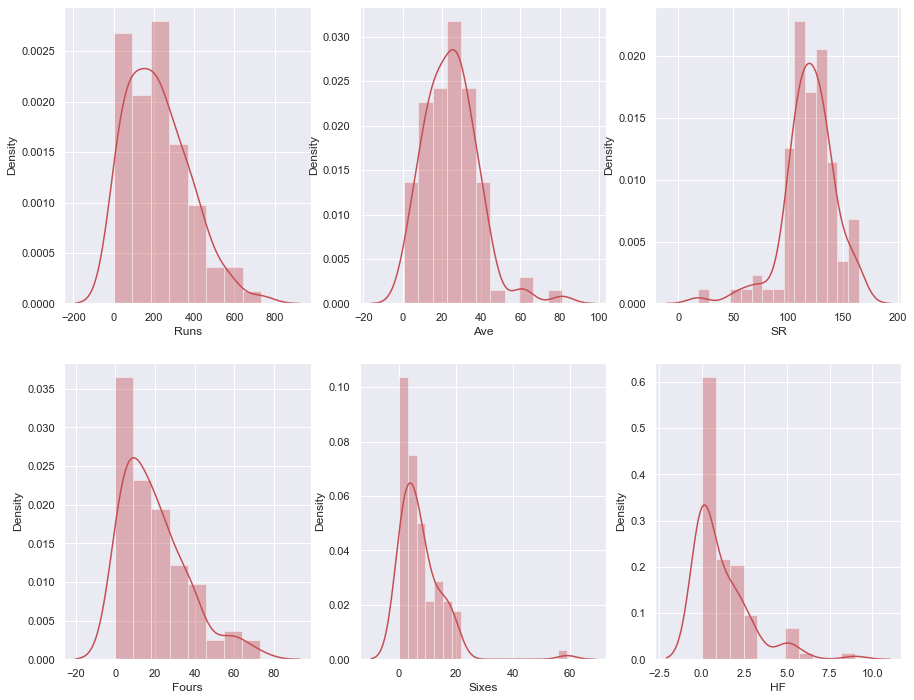

In [159]:
plt.figure(figsize=(15, 12))
col = 1
for i in ipl.drop(columns='Name').columns:
    plt.subplot(2, 3, col)
    sns.distplot(ipl[i], color = 'r')
    col += 1


Strike rate, fours, sixes and half centuries have a skewed distribution

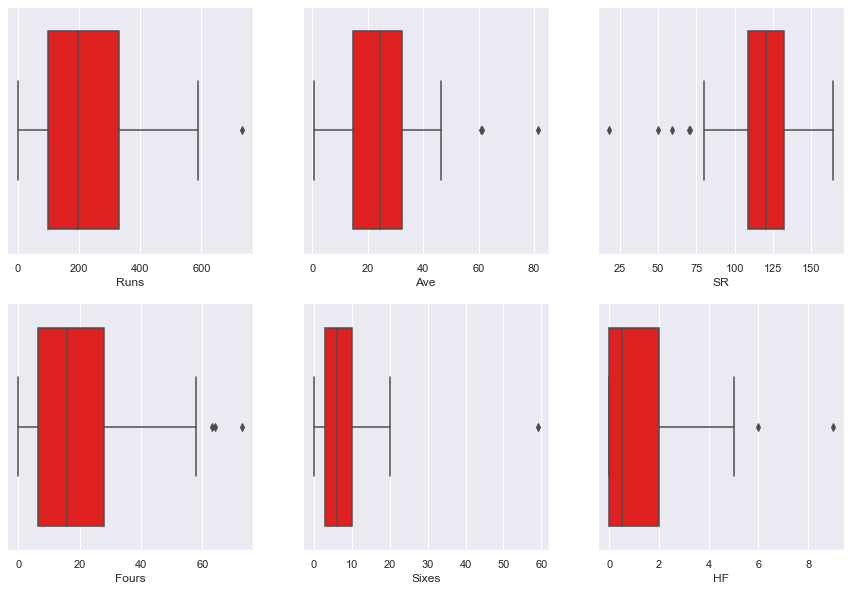

In [160]:
# Finding Outliers via boxplots

plt.figure(figsize=(15, 10))
col = 1
for i in ipl.drop(columns = 'Name').columns:
    plt.subplot(2, 3, col)
    sns.boxplot(ipl[i], color = 'red')
    col += 1

#### There appears to be outliers in SR, sizes, fours, HF, will not be treating them as its highly likely that these are genuine observation and are definately player dependent.

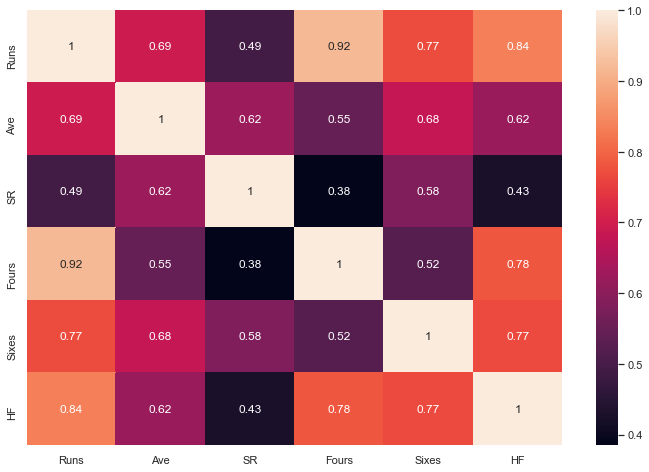

In [161]:
#checking for correlation

plt.figure(figsize = (12,8))
corr = ipl.drop(columns = 'Name').corr()
sns.heatmap(corr, annot = True);

All the variable except fours with strike rate, strike rate with half centuries,strike rate with runs, have high correlation

In [162]:
#scaling the numeric variables
cc = ipl.iloc[:,1:7] 
cc1 = cc.apply(zscore)
cc1.head()

,Runs,Ave,SR,Fours,Sixes,HF
1,3.301945,2.683984,1.767325,1.607207,6.462679,4.651551
3,2.381639,0.896390,1.036605,2.710928,1.184173,2.865038
5,1.770248,0.610640,1.788154,2.281703,1.435530,2.269533
7,1.667276,1.388883,1.297182,1.300618,1.561209,2.269533
9,2.246490,1.174755,0.444038,2.343021,1.309851,2.269533


In [163]:
#checking for the within sum of squares
wss =[] 
for i in range(1,6):
    KM = KMeans(n_clusters=i)
    KM.fit(cc1)
    wss.append(KM.inertia_)
wss

[540.0000000000001,
 296.26135354732025,
 223.36518460916952,
 178.1750796759041,
 149.54597519141365]

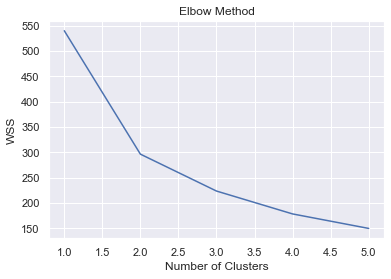

In [164]:
#plotting to check for optimal clustres 
plt.plot(range(1,6), wss);
plt.title('Elbow Method');
plt.xlabel("Number of Clusters")
plt.ylabel("WSS");

#### clear indication from above elbow bend, that we can segregate players into 2 categories/groups

In [165]:
#using 2 centroids

k_means = KMeans(n_clusters = 2)
k_means.fit(cc1)
labels = k_means.labels_

In [166]:
# Calculating silhouette_score
silhouette_score(cc1,labels)

0.41111085574076756

In [167]:
#plotting silhouette score for different centroids
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}

silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(cc1)
    score = silhouette_score(cc1,kmeans.labels_)
    silhouette_coefficients.append(score)

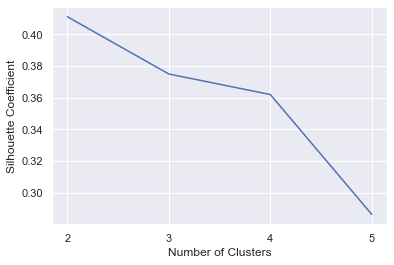

In [168]:
plt.plot(range(2,6), silhouette_coefficients)
plt.xticks(range(2, 6))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [169]:
#attaching the labels to the original data
ipl['cluster'] = labels
ipl.head()

,Name,Runs,Ave,SR,Fours,Sixes,HF,cluster
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0,1
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0,1
5,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0,1
7,CL White,479.0,43.54,149.68,41.0,20.0,5.0,1
9,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0,1


In [170]:
ipl.cluster.value_counts().sort_index()

0    55
1    35
Name: cluster, dtype: int64

In [171]:
#aggregating the clusters with the numeric variables with their mean
aggdata = ipl.iloc[:,0:9].groupby('cluster').mean()
aggdata['Freq'] = ipl.cluster.value_counts().sort_index()
aggdata

,Runs,Ave,SR,Fours,Sixes,HF,Freq
cluster,,,,,,,
0,122.745455,17.582000,110.481455,10.309091,3.636364,0.218182,55
1,372.657143,35.962286,132.808286,34.685714,13.771429,2.714286,35


In [172]:
ipl['cluster'] = ipl['cluster'].replace({1: 'Grade A', 0: 'Grade B'})

In [173]:
#list of Grade A players
Grade_A = ipl[ipl['cluster'] == 'Grade A']
Grade_A.head(10)

,Name,Runs,Ave,SR,Fours,Sixes,HF,cluster
1,CH Gayle,733.0,61.08,160.74,46.0,59.0,9.0,Grade A
3,G Gambhir,590.0,36.87,143.55,64.0,17.0,6.0,Grade A
5,V Sehwag,495.0,33.00,161.23,57.0,19.0,5.0,Grade A
7,CL White,479.0,43.54,149.68,41.0,20.0,5.0,Grade A
9,S Dhawan,569.0,40.64,129.61,58.0,18.0,5.0,Grade A
11,AM Rahane,560.0,40.00,129.33,73.0,10.0,5.0,Grade A
13,KP Pietersen,305.0,61.00,147.34,22.0,20.0,3.0,Grade A
15,RG Sharma,433.0,30.92,126.60,39.0,18.0,5.0,Grade A
17,AB de Villiers,319.0,39.87,161.11,26.0,15.0,3.0,Grade A
19,JP Duminy,244.0,81.33,128.42,13.0,11.0,2.0,Grade A


In [174]:
#list of Grade B players
Grade_B = ipl[ipl['cluster'] == 'Grade B']
Grade_B.head()

,Name,Runs,Ave,SR,Fours,Sixes,HF,cluster
69,MS Bisla,213.0,30.42,133.12,16.0,10.0,1.0,Grade B
73,BJ Hodge,245.0,30.62,140.00,18.0,9.0,0.0,Grade B
75,NV Ojha,255.0,23.18,113.83,21.0,13.0,1.0,Grade B
77,DB Das,126.0,42.00,135.48,9.0,6.0,0.0,Grade B
79,AC Gilchrist,172.0,34.40,120.27,21.0,4.0,1.0,Grade B


## Part 5/5

### Question - List of all Possible Dimensionality Techniques and when to use them
Dimensionality reduction techniques can be classified into two 3 types, Please find below

## Feature selection:

- Missing Value Ratio: If the dataset has too many missing values, we use this approach to reduce the number of variables. We can drop the variables having a large number of missing values in them
 - Low Variance filter: We apply this approach to identify and drop constant variables from the dataset. The target variable is not unduly affected by variables with low variance, and hence these variables can be safely dropped
 - High Correlation filter: A pair of variables having high correlation increases multicollinearity in the dataset. So, we can use this technique to find highly correlated features and drop them accordingly
 - Random Forest: This is one of the most commonly used techniques which tells us the importance of each feature present in the dataset. We can find the importance of each feature and keep the top most features, resulting in dimensionality reduction
 - Both Backward Feature Elimination and Forward Feature Selection techniques take a lot of computational time and are thus generally used on smaller datasets


## Components / Factor Based:

 - Factor Analysis: This technique is best suited for situations where we have highly correlated set of variables. It divides the variables based on their correlation into different groups, and represents each group with a factor
 - Principal Component Analysis: This is one of the most widely used techniques for dealing with linear data. It divides the data into a set of components which try to explain as much variance as possible
 - Independent Component Analysis: We can use ICA to transform the data into independent components which describe the data using less number of components

## Projection Based:

 - ISOMAP: We use this technique when the data is strongly non-linear
 - t-SNE: This technique also works well when the data is strongly non-linear. It works extremely well for visualizations as well
 - UMAP: This technique works well for high dimensional data. Its run-time is shorter as compared to t-SNE

### Question - 
So far you have used dimensional reduction on numeric data. Is it possible to do the same on a multimedia data [images and video] and text data ? Please illustrate your findings using a simple implementation on python.

In [175]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

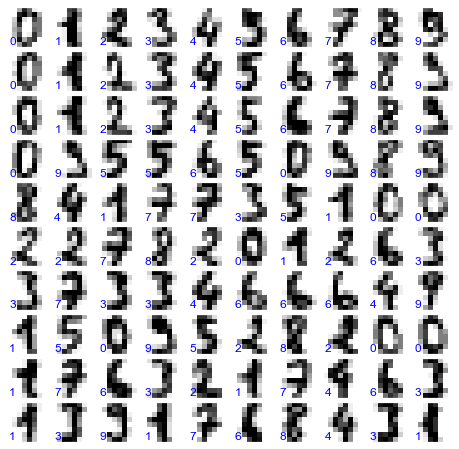

In [176]:
# visualize the first hundred of these
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 10, figsize = (8, 8),
subplot_kw = {'xticks':[], 'yticks':[]},
gridspec_kw = dict(hspace = 0.1, wspace = 0.1))

for i,ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap = 'binary', interpolation = 'nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
    transform=ax.transAxes, color = 'blue')

In [177]:
#two-dimensional,[n_samples, n_features] representation
X = digits.data
X.shape

(1797, 64)

In [178]:
y = digits.target
y.shape


(1797,)

In [179]:
#transform the data to two dimensions using manifold learning algorithm called Isomap

from sklearn.manifold import Isomap
iso = Isomap(n_components = 2)
iso.fit(digits.data)
data_projected = iso.transform(digits.data)
data_projected.shape

(1797, 2)

The projected data is now two-dimensional

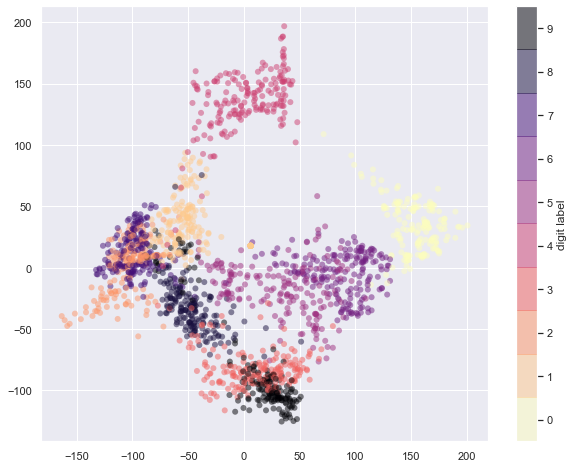

In [180]:
# plot this data to see if we can learn anything from its structure 

plt.figure(figsize=(10, 8))
plt.scatter(data_projected[:, 0], data_projected[:, 1], c=digits.target,edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('magma_r', 10))
plt.colorbar(label='digit label', ticks=range(10))
plt.clim(-0.5, 9.5);

In [181]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [182]:
#fit a Gaussian naive Bayes model
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [183]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.8518518518518519

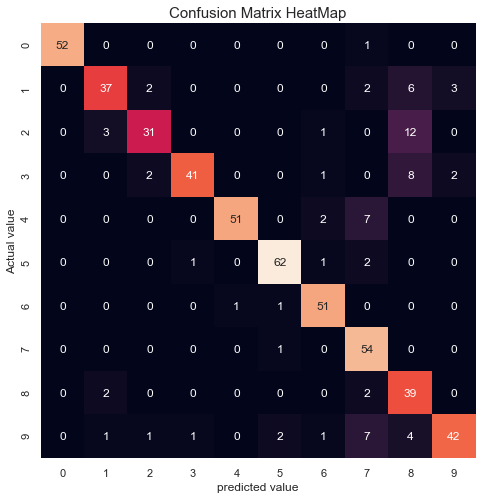

In [184]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline 
sns.set(color_codes = True)

plt.figure(figsize = (12, 8))
mat = confusion_matrix(y_test, pred)
sns.heatmap(mat, square = True, annot = True, cbar = False)
plt.xlabel('predicted value')
plt.ylabel('Actual value');
plt.title('Confusion Matrix HeatMap', fontsize = 15);

Another way to gain intuition into the characteristics of the model is to plot the inputs again, with their predicted labels. 
We will use **blue** for correct labels, and **red** for incorrect labels

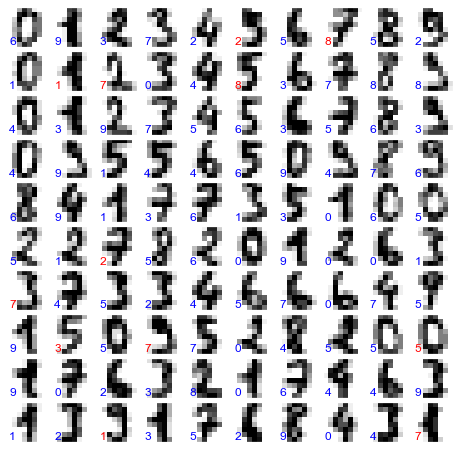

In [185]:
fig, axes = plt.subplots(10, 10, figsize = (8, 8),
 subplot_kw = {'xticks':[], 'yticks':[]},
 gridspec_kw = dict(hspace=0.1, wspace = 0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap ='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(pred[i]),
    transform = ax.transAxes,
    color = 'blue' if (y_test[i] == pred[i]) else 'red')